In [1]:
import pandas as pd
import numpy as np
import re
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Configurar seed para reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

2025-12-03 19:00:27.703108: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.20.0
Keras version: 3.12.0


In [19]:
# 1. Cargar datos del NTD
file_path = "/home/carlos/IA/FINAL/time-series_forecasting/September 2025 Complete Monthly Ridership (with adjustments and estimates)_251103 (1).xlsx"
data = pd.read_excel(file_path, sheet_name="UPT", header=0)

# 2. Eliminar columnas posteriores a 2023
cols_to_drop = []
for col in data.columns:
    if "/" in col:
        mes, año = col.split("/")
        if año.isdigit() and int(año) > 2023:
            cols_to_drop.append(col)
data = data.drop(columns=cols_to_drop)

# 3. Filtrar solo Heavy Rail (HR) y excluir Honolulu/San Juan
data = data[~data["UZA Name"].isin(["Honolulu, HI", "San Juan, PR"])]
new_rows = []
for idx, row in data.iterrows():
    if str(row["Mode"]) == "HR" or str(row["NTD ID"]) == "NTD ID":
        new_rows.append(row)
newData = pd.DataFrame(new_rows).reset_index(drop=True)

# 4. Extraer columnas de fechas
date_cols = [c for c in newData.columns if isinstance(c, str) and re.match(r"^\d{1,2}/\d{4}$", c)]
dates = pd.to_datetime(date_cols, format="%m/%Y")

# 5. Crear diccionario de DataFrames por agencia (en pandas)
agency_dataframes = {}
agency_names_list = []

for idx, row in newData.iterrows():
    agency_name = row["Agency"]
    agency_names_list.append(agency_name)
    
    # Crear DataFrame con fechas y valores para cada agencia
    agency_df = pd.DataFrame({
        'date': dates,
        'ridership': row[date_cols].values.astype(float)
    })
    agency_df.set_index('date', inplace=True)
    
    # Guardar en diccionario con clave agencia{i}
    agency_dataframes[f"agencia{idx+1}"] = agency_df

# Mantener raw_data como numpy para compatibilidad con código existente
raw_data = newData[date_cols].to_numpy(dtype=float)

print(f"\n✅ Datos cargados: {len(agency_dataframes)} agencias, {len(dates)} meses")
print(f"Rango de fechas: {dates[0]} → {dates[-1]}")
print(f"\nAgencias:")
for i, name in enumerate(agency_names_list, 1):
    print(f"  agencia{i}: {name}")

print(f"\n📊 Ejemplo de DataFrame para agencia1:")
print(agency_dataframes["agencia1"].head())
print(f"\nShape: {agency_dataframes['agencia1'].shape}")


✅ Datos cargados: 14 agencias, 264 meses
Rango de fechas: 2002-01-01 00:00:00 → 2023-12-01 00:00:00

Agencias:
  agencia1: Massachusetts Bay Transportation Authority
  agencia2: MTA New York City Transit
  agencia3: Port Authority Transit Corporation
  agencia4: Port Authority Trans-Hudson Corporation
  agencia5: Staten Island Rapid Transit Operating Authority
  agencia6: Southeastern Pennsylvania Transportation Authority
  agencia7: Washington Metropolitan Area Transit Authority
  agencia8: Maryland Transit Administration
  agencia9: Metropolitan Atlanta Rapid Transit Authority
  agencia10: County of Miami-Dade 
  agencia11: The Greater Cleveland Regional Transit Authority
  agencia12: Chicago Transit Authority
  agencia13: San Francisco Bay Area Rapid Transit District
  agencia14: Los Angeles County Metropolitan Transportation Authority 

📊 Ejemplo de DataFrame para agencia1:
             ridership
date                  
2002-01-01   9952800.0
2002-02-01   9753800.0
2002-03-01  1046

In [20]:
df_chicago = agency_dataframes["agencia1"]

In [21]:
df_chicago 

ridership
date                  
2002-01-01   9952800.0
2002-02-01   9753800.0
2002-03-01  10469800.0
2002-04-01  10736100.0
2002-05-01  10526600.0
...                ...
2023-08-01   7872552.0
2023-09-01   7549343.0
2023-10-01   7629155.0
2023-11-01   6772827.0
2023-12-01   6435183.0

[264 rows x 1 columns]

<Axes: xlabel='date'>

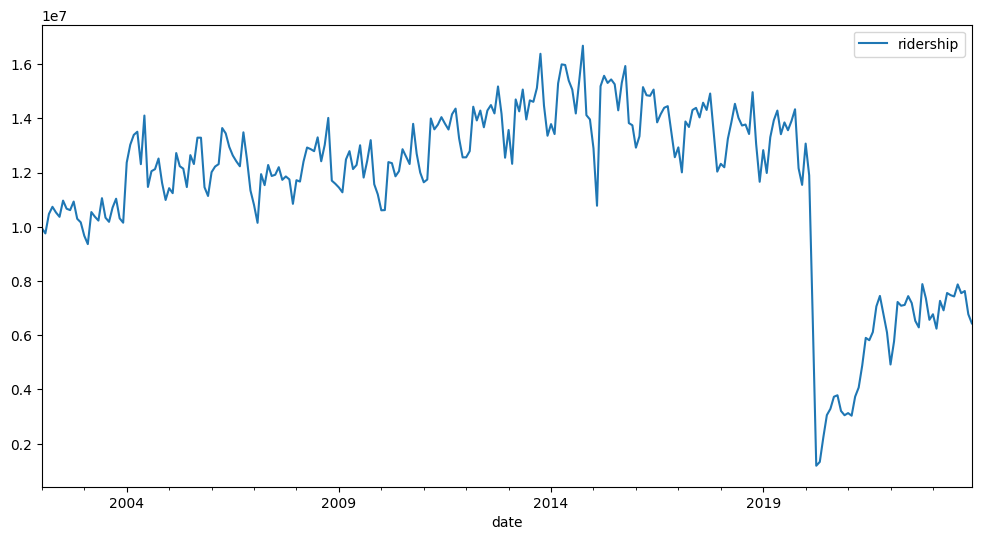

In [23]:
df_chicago.plot(figsize=(12,6))


In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose


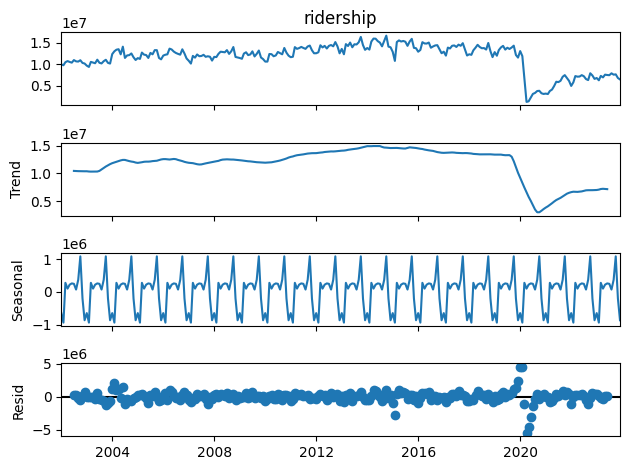

In [25]:
results = seasonal_decompose(df_chicago['ridership'])
results.plot();

In [26]:
len(df_chicago)

264

In [27]:
train = df_chicago.iloc[:252]
test = df_chicago.iloc[252:]

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [29]:
df_chicago.head(),df_chicago.tail()


(             ridership
 date                  
 2002-01-01   9952800.0
 2002-02-01   9753800.0
 2002-03-01  10469800.0
 2002-04-01  10736100.0
 2002-05-01  10526600.0,
             ridership
 date                 
 2023-08-01  7872552.0
 2023-09-01  7549343.0
 2023-10-01  7629155.0
 2023-11-01  6772827.0
 2023-12-01  6435183.0)

In [30]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [31]:
scaled_train[:10]


array([[0.56593002],
       [0.55308947],
       [0.59928963],
       [0.61647273],
       [0.60295467],
       [0.59262416],
       [0.63121678],
       [0.61191724],
       [0.60858128],
       [0.62896484]])

In [33]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


In [34]:
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
     

In [35]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.56593002 0.55308947 0.59928963]
Predict this y: 
 [[0.61647273]]


In [36]:
X.shape


(1, 3, 1)

In [37]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
     

In [38]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [39]:

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model.fit(generator,epochs=50)


Epoch 1/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0357
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0357
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0122
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0122
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0106
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0106
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0089
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0089
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0099
Epoch 6/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0099
Epoch 6/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0088
Epoch 7/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0088
Epoch 7/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0085
Epoch 8/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0085
Epoch 8/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/

In [42]:
last_train_batch = scaled_train[-12:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
model.predict(last_train_batch)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


array([[0.33985922]], dtype=float32)

In [43]:
scaled_test[0]


array([0.36063141])

In [44]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
     

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


In [45]:
test.head()


ridership
date                 
2023-01-01  6771127.0
2023-02-01  6239382.0
2023-03-01  7266019.0
2023-04-01  6915755.0
2023-05-01  7555508.0

/tmp/ipykernel_68881/2154171671.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='date'>

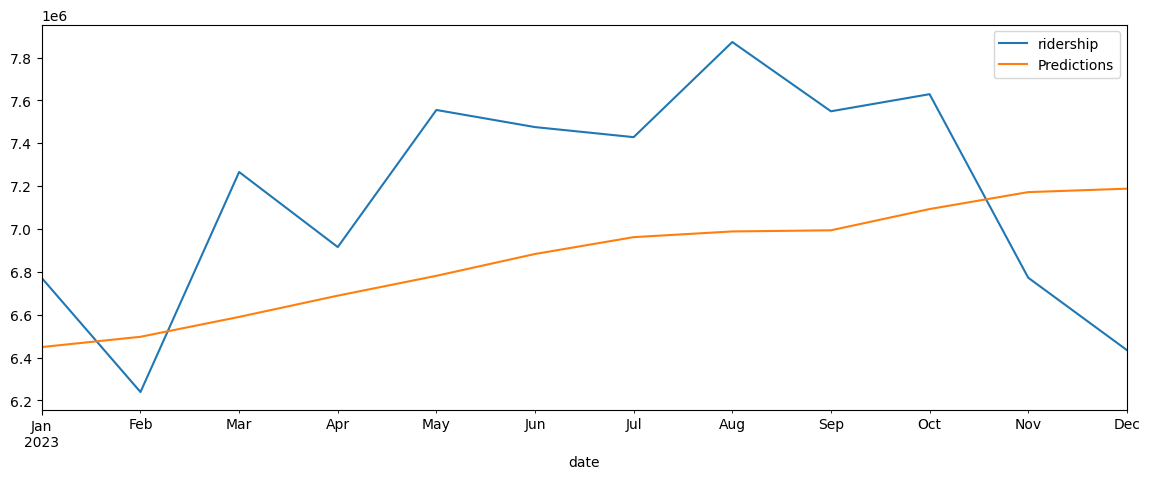

In [46]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.plot(figsize=(14,5))


In [48]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['ridership'],test['Predictions']))
print(rmse)
     

573689.0382372814


In [49]:
# Configuración de escenarios (igual que R)
SCENARIOS = {
    "full": {
        "train_end": 252,  # 2002-01 → 2022-12
        "test_start": 252,
        "test_end": 264,   # 2023-01 → 2023-12
        "description": "Full Series: Train 2002-2022, Test 2023"
    },
    "precovid": {
        "train_end": 206,  # 2002-01 → 2019-02
        "test_start": 206,
        "test_end": 218,   # 2019-03 → 2020-02
        "description": "Pre-COVID: Train 2002-2019-02, Test 2019-03 to 2020-02"
    },
    "postcovid": {
        "train_start": 219,  # 2020-04
        "train_end": 252,    # → 2022-12
        "test_start": 252,
        "test_end": 264,     # 2023-01 → 2023-12
        "description": "Post-COVID: Train 2020-04 to 2022-12, Test 2023"
    }
}

# Hiperparámetros
n_input = 12  # Ventana de 12 meses
n_features = 1
n_epochs = 50

print("✅ Configuración de escenarios lista")

✅ Configuración de escenarios lista


In [50]:
# Función para preparar datos según escenario
def prepare_scenario_data(df, scenario):
    """Prepara train/test según escenario"""
    config = SCENARIOS[scenario]
    
    if scenario == "postcovid":
        train = df.iloc[config["train_start"]:config["train_end"]]
    else:
        train = df.iloc[:config["train_end"]]
    
    test = df.iloc[config["test_start"]:config["test_end"]]
    
    return train, test

# Función para crear modelos
def build_dense_model(n_input, n_features):
    """Red Neuronal Densa"""
    model = Sequential()
    model.add(Dense(16, activation='relu', input_shape=(n_input * n_features,)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def build_cnn_model(n_input, n_features):
    """CNN"""
    from keras.layers import Conv1D, MaxPooling1D, Flatten
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_input, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm_model(n_input, n_features):
    """LSTM"""
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

print("✅ Funciones de preparación y modelos creadas")

✅ Funciones de preparación y modelos creadas


In [54]:
# Función para entrenar y evaluar un modelo
def train_and_evaluate(model, model_name, scenario, agencia_id, agencia_name, df):
    """Entrena y evalúa un modelo para una agencia"""
    
    print(f"\n{'='*70}")
    print(f" {agencia_name} - {model_name.upper()} - {scenario.upper()}")
    print(f"{'='*70}")
    
    # 1. Preparar datos
    train, test = prepare_scenario_data(df, scenario)
    
    # 2. Escalar datos
    scaler = MinMaxScaler()
    scaled_train = scaler.fit_transform(train)
    scaled_test = scaler.transform(test)
    
    # 3. Crear generador
    generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
    
    # 4. Entrenar modelo
    print(f" Entrenando...")
    if model_name == "dense":
        # Para Dense, necesitamos aplanar los datos
        X_train = []
        y_train = []
        for i in range(len(generator)):
            x, y = generator[i]
            X_train.append(x.flatten())
            y_train.append(y)
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        
        history = model.fit(X_train, y_train, epochs=n_epochs, verbose=0)
    else:
        history = model.fit(generator, epochs=n_epochs, verbose=0)
    
    # 5. Hacer predicciones
    test_predictions = []
    first_eval_batch = scaled_train[-n_input:]
    
    if model_name == "dense":
        current_batch = first_eval_batch.flatten().reshape(1, -1)
    else:
        current_batch = first_eval_batch.reshape((1, n_input, n_features))
    
    for i in range(len(test)):
        current_pred = model.predict(current_batch, verbose=0)[0]
        test_predictions.append(current_pred)
        
        if model_name == "dense":
            current_batch = np.append(current_batch[:, n_features:], current_pred).reshape(1, -1)
        else:
            current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)
    
    # 6. Desnormalizar predicciones
    true_predictions = scaler.inverse_transform(test_predictions)
    
    # 7. Calcular métricas
    rmse = sqrt(mean_squared_error(test['ridership'].values, true_predictions))
    mape = np.mean(np.abs((test['ridership'].values - true_predictions.flatten()) / test['ridership'].values)) * 100
    
    # MASE (Mean Absolute Scaled Error)
    y_true = test['ridership'].values
    y_pred = true_predictions.flatten()
    y_train = train['ridership'].values
    
    # MAE de las predicciones
    mae = np.mean(np.abs(y_true - y_pred))
    
    # MAE del naive seasonal (m=12 para datos mensuales)
    m = 12
    naive_errors = np.abs(y_train[m:] - y_train[:-m])
    scale = np.mean(naive_errors)
    
    mase = mae / scale if scale > 0 else np.inf
    
    print(f"📊 RMSE: {rmse:.2f}")
    print(f"📊 MAPE: {mape:.2f}%")
    print(f"📊 MASE: {mase:.3f}")
    
    # 8. Guardar resultados
    results_df = test.copy()
    results_df['Predictions'] = true_predictions
    
    return {
        'agencia_id': agencia_id,
        'agencia_name': agencia_name,
        'model': model_name,
        'scenario': scenario,
        'rmse': rmse,
        'mape': mape,
        'mase': mase,
        'test_data': test,
        'predictions': true_predictions.flatten(),
        'results_df': results_df,
        'train': train
    }

print("✅ Función de entrenamiento creada")

✅ Función de entrenamiento creada


In [63]:
# Función para crear plots agrupados (14 agencias) estilo simple
def plot_grouped_agencies(all_results, model_name, scenario):
    """Crea 14 plots (uno por agencia) para un modelo y escenario específico"""
    
    # Filtrar resultados para este modelo y escenario
    filtered_results = [r for r in all_results if r['model'] == model_name and r['scenario'] == scenario]
    
    if len(filtered_results) == 0:
        return
    
    # Crear grid 7x2 con más altura para evitar compresión
    fig, axes = plt.subplots(7, 2, figsize=(24, 35))
    axes = axes.flatten()
    
    for idx, result in enumerate(filtered_results):
        ax = axes[idx]
        
        train = result['train']
        test = result['test_data']
        predictions = result['predictions']
        
        # Plot usando matplotlib directamente (sin pandas.plot para evitar conflictos)
        # Training data (negro)
        ax.plot(train.index, train['ridership'], 'k-', 
                linewidth=1.2, label='Training', alpha=0.6)
        
        # Test real (rojo)
        ax.plot(test.index, test['ridership'], 'r-', 
                linewidth=2, label='Real')
        
        # Predicciones (azul punteado)
        ax.plot(test.index, predictions, 'b--', 
                linewidth=2, label='Predictions')
        
        # COVID line
        if scenario in ["full", "precovid"]:
            ax.axvline(pd.Timestamp("2020-03-01"), color='gray', 
                      linestyle='--', linewidth=1, alpha=0.5)
        
        # Título con métricas
        title = f"{result['agencia_name']}\n"
        title += f"MAPE: {result['mape']:.2f}% | MASE: {result['mase']:.3f}"
        ax.set_title(title, fontsize=10, fontweight='bold')
        ax.set_xlabel("")
        ax.set_ylabel("Ridership", fontsize=9)
        ax.legend(loc='best', fontsize=8, framealpha=0.9)
        ax.grid(True, alpha=0.3)
        
        # Formato de fechas
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
    
    # Título general
    fig.suptitle(
        f"{model_name.upper()} - {scenario.upper()}\n{SCENARIOS[scenario]['description']}",
        fontsize=18, fontweight="bold", y=0.998
    )
    
    plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Más espacio entre subplots
    
    # Guardar
    output_dir = f"/home/carlos/IA/FINAL/time-series_forecasting/plots/{scenario}_{model_name}"
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f"all_agencies_{scenario}_{model_name}.png")
    plt.savefig(output_path, dpi=120, bbox_inches="tight")
    print(f"\n💾 Plot guardado: {output_path}")
    
    plt.show()
    plt.close()

print("✅ Función de plots agrupados creada")

✅ Función de plots agrupados creada



🚀 INICIO DEL ENTRENAMIENTO COMPLETO
Modelos: DENSE, CNN, LSTM
Escenarios: FULL, PRECOVID, POSTCOVID
Total: 3 × 3 × 14 = 126 modelos

################################################################################
################################################################################
## ENTRENANDO: DENSE - FULL
################################################################################
################################################################################

 Massachusetts Bay Transportation Authority - DENSE - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 2108305.43
📊 MAPE: 28.50%
📊 MASE: 1.497

 MTA New York City Transit - DENSE - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 7733320.49
📊 MAPE: 3.90%
📊 MASE: 0.314

 Port Authority Transit Corporation - DENSE - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 74837.12
📊 MAPE: 14.86%
📊 MASE: 0.868


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



 Port Authority Trans-Hudson Corporation - DENSE - FULL
 Entrenando...
📊 RMSE: 912283.69
📊 MAPE: 17.26%
📊 MASE: 0.963

 Staten Island Rapid Transit Operating Authority - DENSE - FULL
 Entrenando...
📊 RMSE: 912283.69
📊 MAPE: 17.26%
📊 MASE: 0.963

 Staten Island Rapid Transit Operating Authority - DENSE - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 51633.09
📊 MAPE: 8.88%
📊 MASE: 0.530

 Southeastern Pennsylvania Transportation Authority - DENSE - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 1140283.12
📊 MAPE: 23.81%
📊 MASE: 1.339

 Washington Metropolitan Area Transit Authority - DENSE - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 2937099.49
📊 MAPE: 20.55%
📊 MASE: 1.169

 Maryland Transit Administration - DENSE - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 118851.15
📊 MAPE: 57.49%
📊 MASE: 0.814

 Metropolitan Atlanta Rapid Transit Authority - DENSE - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 426835.51
📊 MAPE: 14.68%
📊 MASE: 0.681

 County of Miami-Dade  - DENSE - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 89926.71
📊 MAPE: 6.82%
📊 MASE: 0.533

 The Greater Cleveland Regional Transit Authority - DENSE - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 27783.17
📊 MAPE: 7.59%
📊 MASE: 0.279

 Chicago Transit Authority - DENSE - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 2744504.13
📊 MAPE: 27.09%
📊 MASE: 1.675

 San Francisco Bay Area Rapid Transit District - DENSE - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 1595937.24
📊 MAPE: 32.33%
📊 MASE: 1.482

 Los Angeles County Metropolitan Transportation Authority  - DENSE - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 342690.07
📊 MAPE: 12.88%
📊 MASE: 0.871

💾 Plot guardado: /home/carlos/IA/FINAL/time-series_forecasting/plots/full_dense/all_agencies_full_dense.png

💾 Plot guardado: /home/carlos/IA/FINAL/time-series_forecasting/plots/full_dense/all_agencies_full_dense.png


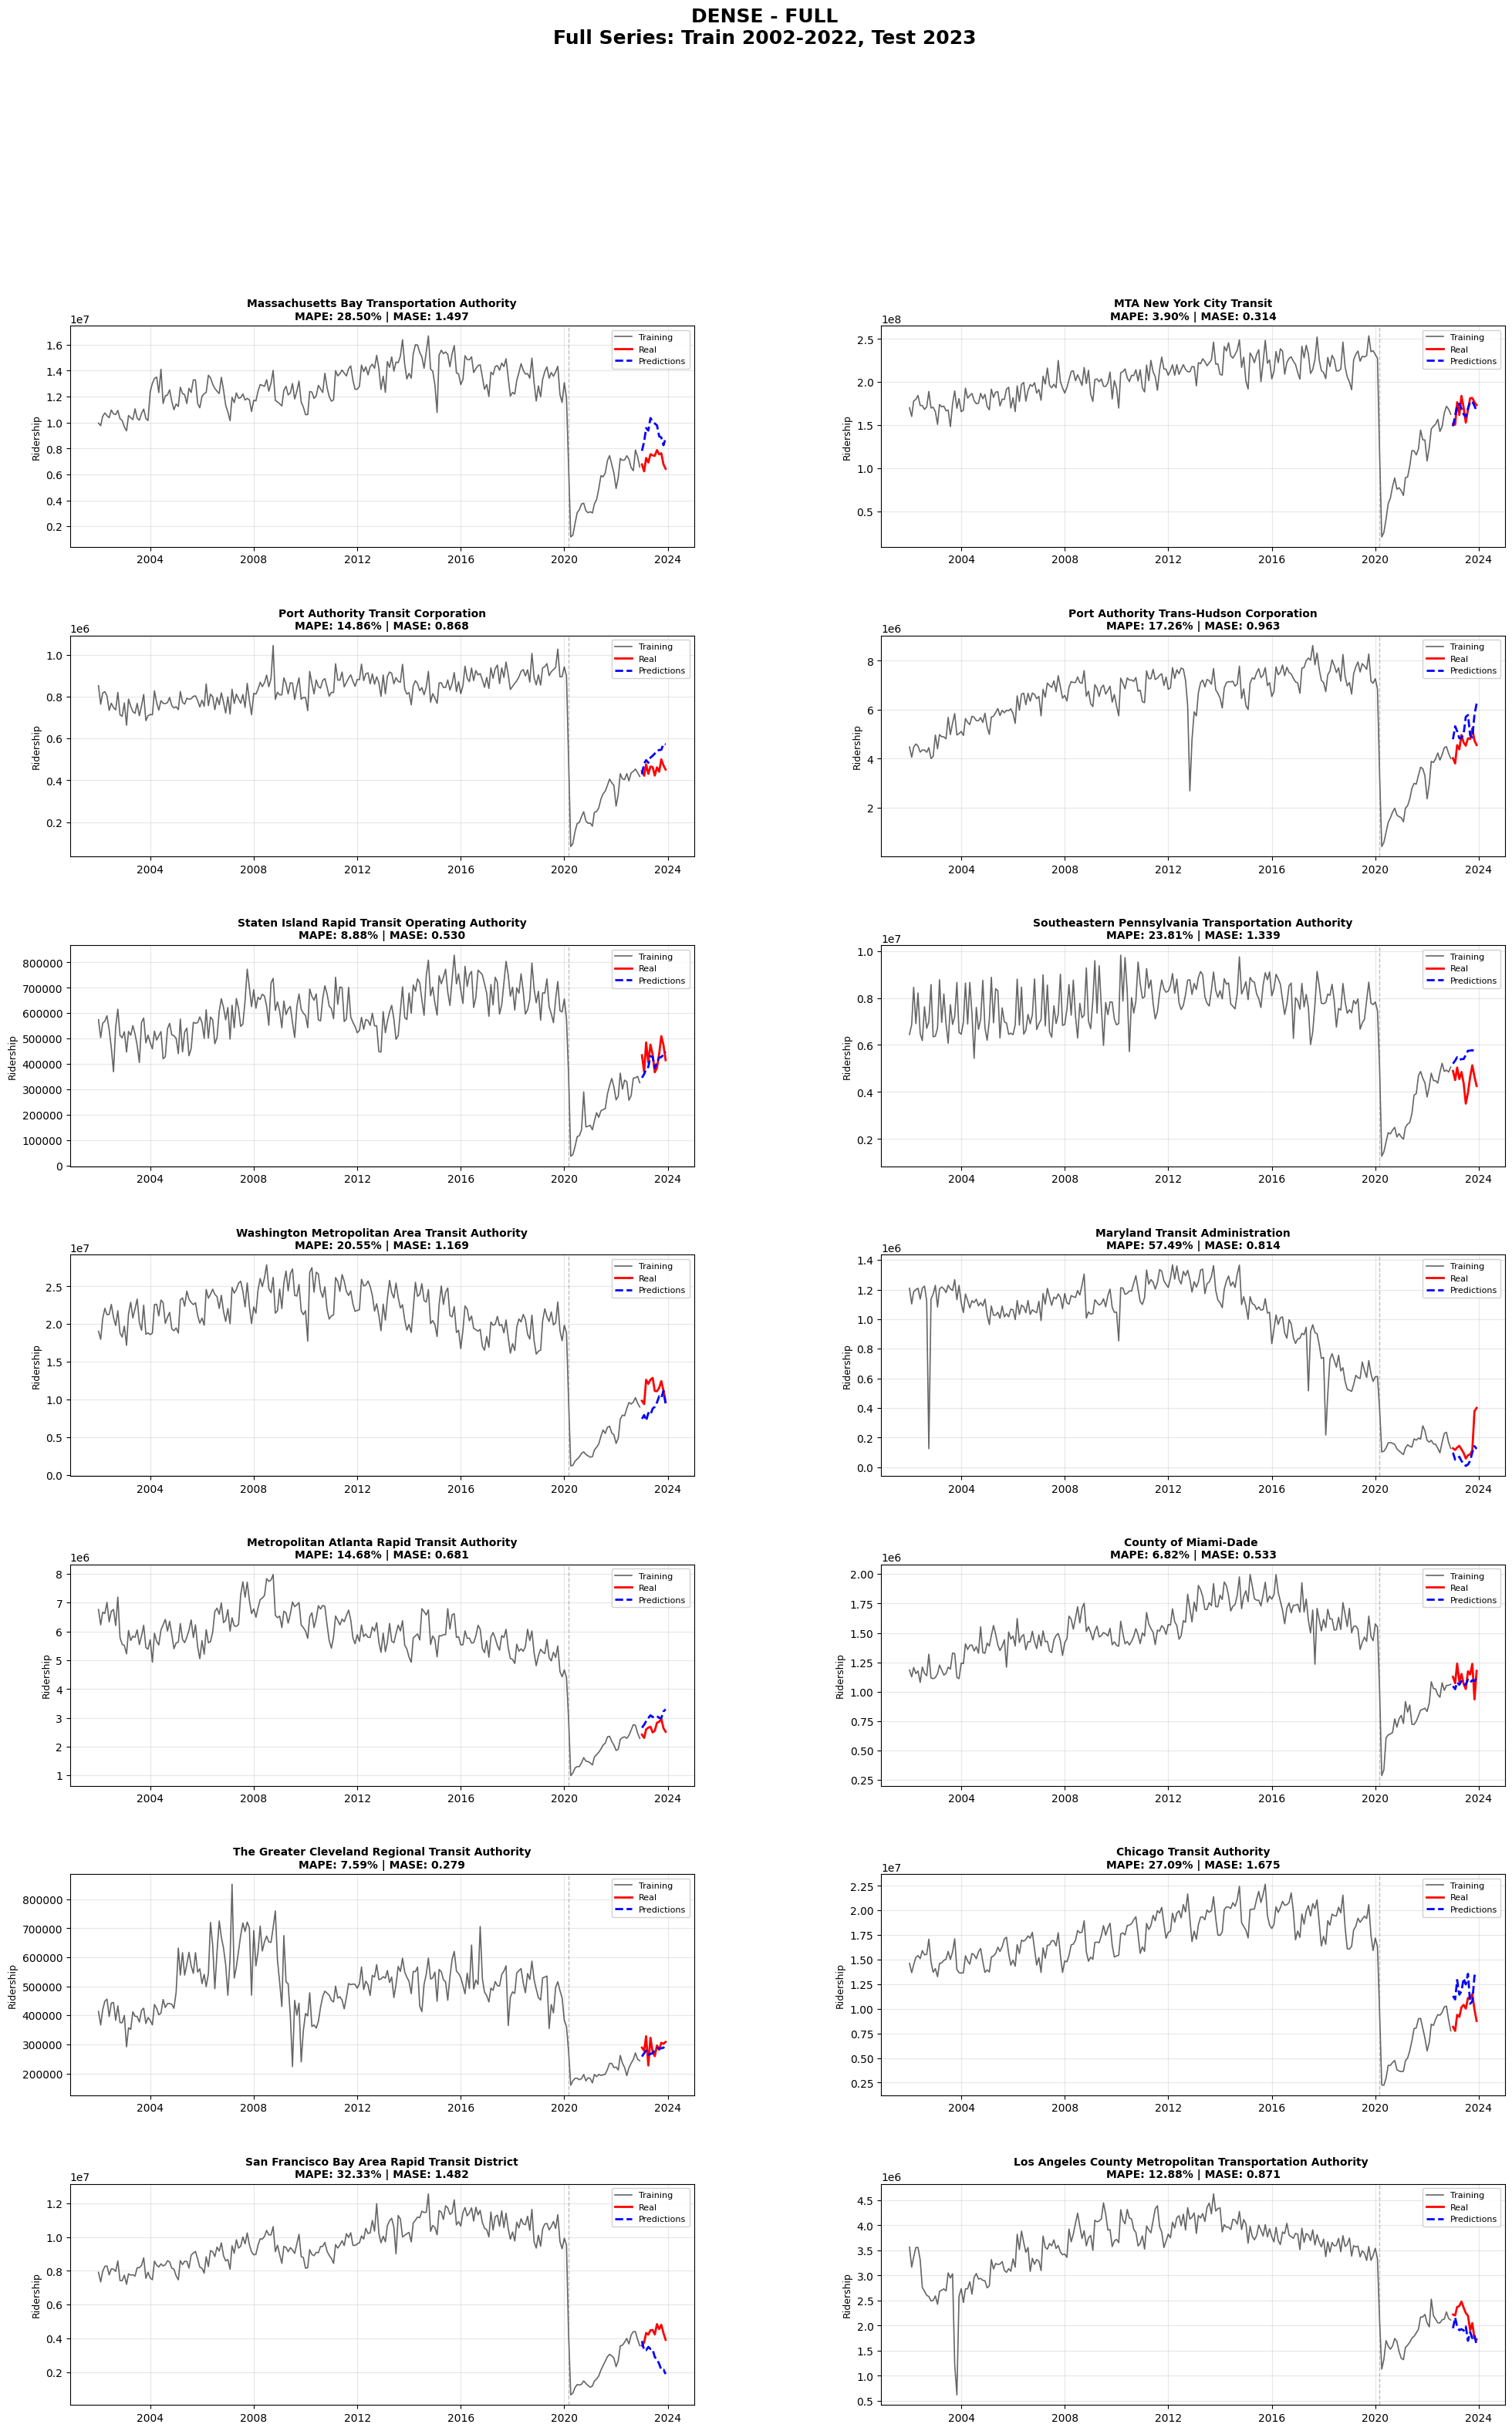


################################################################################
################################################################################
## ENTRENANDO: CNN - FULL
################################################################################
################################################################################

 Massachusetts Bay Transportation Authority - CNN - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 1331493.13
📊 MAPE: 16.98%
📊 MASE: 0.880

 MTA New York City Transit - CNN - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 15433236.80
📊 MAPE: 8.16%
📊 MASE: 0.632

 Port Authority Transit Corporation - CNN - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 61504.50
📊 MAPE: 10.97%
📊 MASE: 0.642

 Port Authority Trans-Hudson Corporation - CNN - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 615795.21
📊 MAPE: 12.77%
📊 MASE: 0.727

 Staten Island Rapid Transit Operating Authority - CNN - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 55416.81
📊 MAPE: 9.87%
📊 MASE: 0.590

 Southeastern Pennsylvania Transportation Authority - CNN - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 500518.36
📊 MAPE: 9.23%
📊 MASE: 0.554

 Washington Metropolitan Area Transit Authority - CNN - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 2141391.74
📊 MAPE: 15.17%
📊 MASE: 0.875

 Maryland Transit Administration - CNN - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 104481.44
📊 MAPE: 52.70%
📊 MASE: 0.679

 Metropolitan Atlanta Rapid Transit Authority - CNN - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 581447.88
📊 MAPE: 19.80%
📊 MASE: 0.967

 County of Miami-Dade  - CNN - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 113722.02
📊 MAPE: 8.11%
📊 MASE: 0.592

 The Greater Cleveland Regional Transit Authority - CNN - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 42107.57
📊 MAPE: 12.29%
📊 MASE: 0.464

 Chicago Transit Authority - CNN - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 965308.40
📊 MAPE: 7.46%
📊 MASE: 0.513

 San Francisco Bay Area Rapid Transit District - CNN - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 761902.08
📊 MAPE: 14.64%
📊 MASE: 0.634

 Los Angeles County Metropolitan Transportation Authority  - CNN - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 227421.47
📊 MAPE: 9.26%
📊 MASE: 0.593

💾 Plot guardado: /home/carlos/IA/FINAL/time-series_forecasting/plots/full_cnn/all_agencies_full_cnn.png

💾 Plot guardado: /home/carlos/IA/FINAL/time-series_forecasting/plots/full_cnn/all_agencies_full_cnn.png


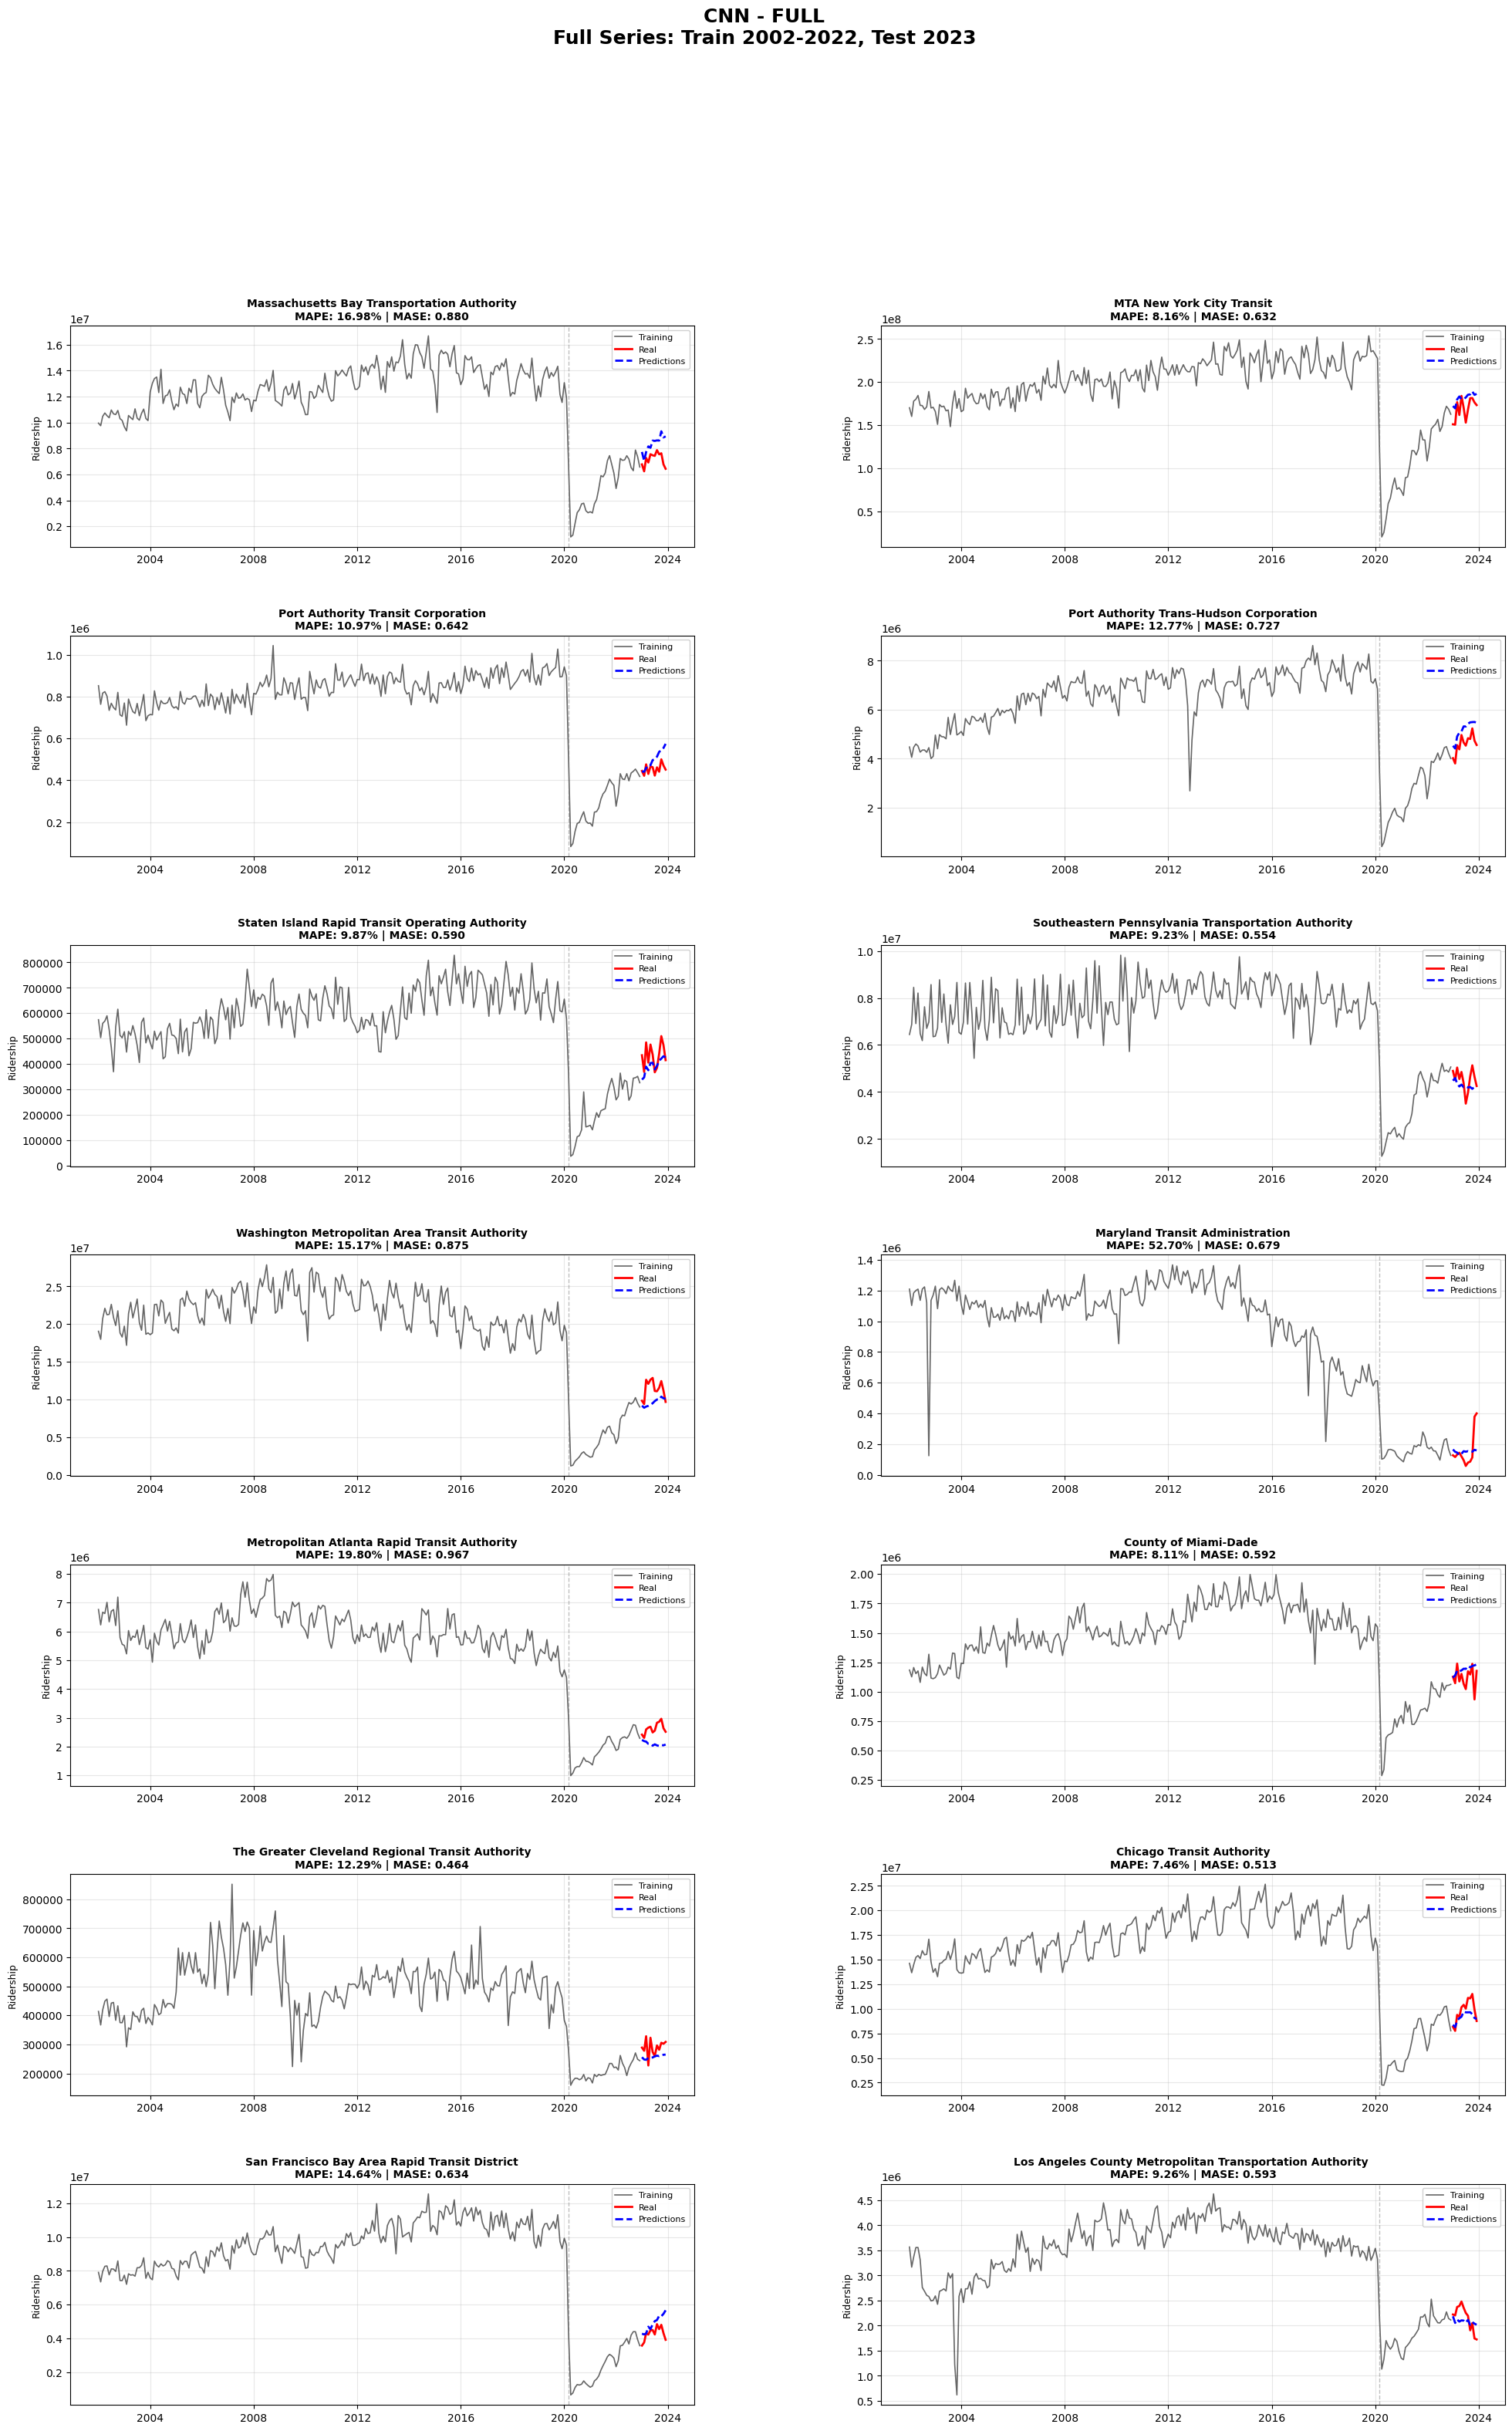


################################################################################
################################################################################
## ENTRENANDO: LSTM - FULL
################################################################################
################################################################################


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 Massachusetts Bay Transportation Authority - LSTM - FULL
 Entrenando...
📊 RMSE: 1314655.85
📊 MAPE: 16.50%
📊 MASE: 0.852
📊 RMSE: 1314655.85
📊 MAPE: 16.50%
📊 MASE: 0.852


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 MTA New York City Transit - LSTM - FULL
 Entrenando...
📊 RMSE: 11931041.19
📊 MAPE: 6.00%
📊 MASE: 0.497

 Port Authority Transit Corporation - LSTM - FULL
 Entrenando...
📊 RMSE: 11931041.19
📊 MAPE: 6.00%
📊 MASE: 0.497

 Port Authority Transit Corporation - LSTM - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 145771.94
📊 MAPE: 27.52%
📊 MASE: 1.623

 Port Authority Trans-Hudson Corporation - LSTM - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 564017.89
📊 MAPE: 11.21%
📊 MASE: 0.633

 Staten Island Rapid Transit Operating Authority - LSTM - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 57103.21
📊 MAPE: 10.21%
📊 MASE: 0.611

 Southeastern Pennsylvania Transportation Authority - LSTM - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 695409.88
📊 MAPE: 12.49%
📊 MASE: 0.672

 Washington Metropolitan Area Transit Authority - LSTM - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 1522381.52
📊 MAPE: 10.76%
📊 MASE: 0.589

 Maryland Transit Administration - LSTM - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 113425.44
📊 MAPE: 81.45%
📊 MASE: 0.900

 Metropolitan Atlanta Rapid Transit Authority - LSTM - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 737138.74
📊 MAPE: 24.10%
📊 MASE: 1.153

 County of Miami-Dade  - LSTM - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 157809.32
📊 MAPE: 12.00%
📊 MASE: 0.890

 The Greater Cleveland Regional Transit Authority - LSTM - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 102070.58
📊 MAPE: 30.65%
📊 MASE: 1.102

 Chicago Transit Authority - LSTM - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 934090.24
📊 MAPE: 6.96%
📊 MASE: 0.434

 San Francisco Bay Area Rapid Transit District - LSTM - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 644524.38
📊 MAPE: 9.85%
📊 MASE: 0.432

 Los Angeles County Metropolitan Transportation Authority  - LSTM - FULL
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 384346.72
📊 MAPE: 14.16%
📊 MASE: 0.807

💾 Plot guardado: /home/carlos/IA/FINAL/time-series_forecasting/plots/full_lstm/all_agencies_full_lstm.png

💾 Plot guardado: /home/carlos/IA/FINAL/time-series_forecasting/plots/full_lstm/all_agencies_full_lstm.png


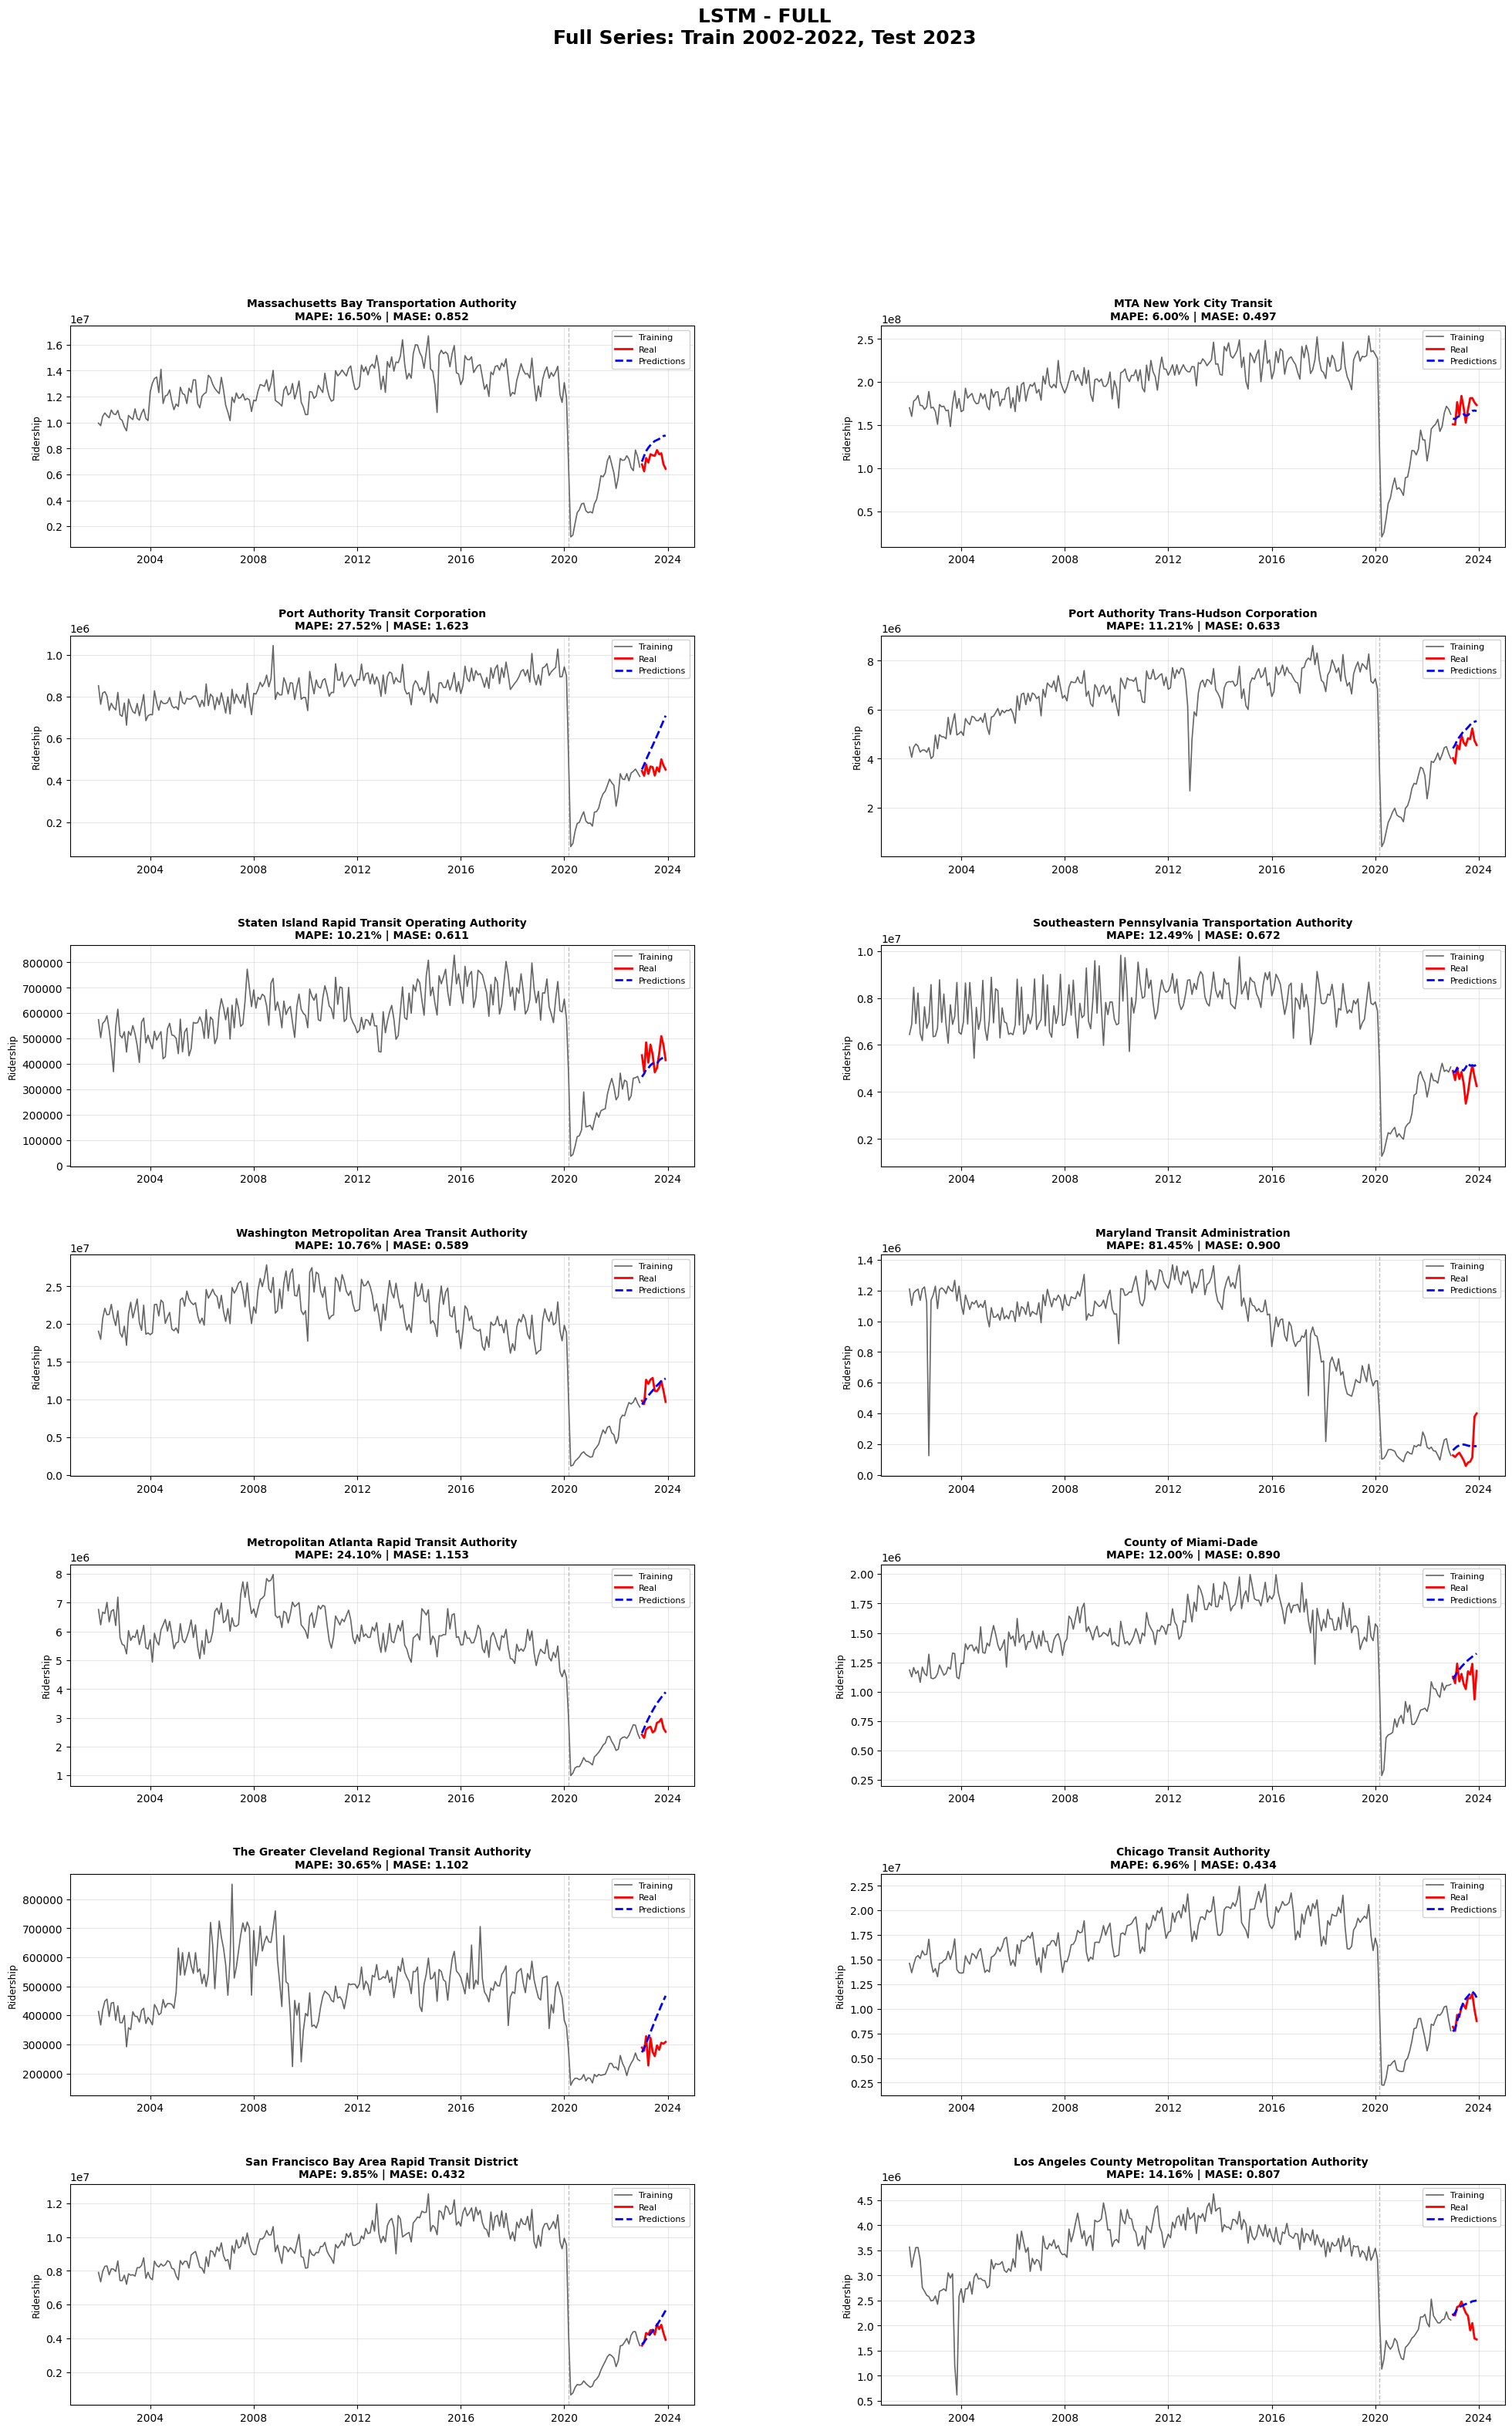


################################################################################
################################################################################
## ENTRENANDO: DENSE - PRECOVID
################################################################################
################################################################################

 Massachusetts Bay Transportation Authority - DENSE - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 838812.82
📊 MAPE: 5.27%
📊 MASE: 0.916

 MTA New York City Transit - DENSE - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 17043511.55
📊 MAPE: 6.71%
📊 MASE: 1.733

 Port Authority Transit Corporation - DENSE - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 57282.21
📊 MAPE: 4.22%
📊 MASE: 1.216

 Port Authority Trans-Hudson Corporation - DENSE - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 341559.02
📊 MAPE: 3.96%
📊 MASE: 0.691

 Staten Island Rapid Transit Operating Authority - DENSE - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 68314.86
📊 MAPE: 10.17%
📊 MASE: 1.302

 Southeastern Pennsylvania Transportation Authority - DENSE - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 548298.94
📊 MAPE: 5.60%
📊 MASE: 1.004

 Washington Metropolitan Area Transit Authority - DENSE - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 2418435.79
📊 MAPE: 10.01%
📊 MASE: 2.055

 Maryland Transit Administration - DENSE - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 72502.76
📊 MAPE: 9.65%
📊 MASE: 0.631

 Metropolitan Atlanta Rapid Transit Authority - DENSE - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 850871.71
📊 MAPE: 15.49%
📊 MASE: 2.030

 County of Miami-Dade  - DENSE - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 127901.32
📊 MAPE: 7.74%
📊 MASE: 1.174

 The Greater Cleveland Regional Transit Authority - DENSE - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 92949.89
📊 MAPE: 18.04%
📊 MASE: 0.982

 Chicago Transit Authority - DENSE - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 1639093.03
📊 MAPE: 7.42%
📊 MASE: 2.168

 San Francisco Bay Area Rapid Transit District - DENSE - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 568896.07
📊 MAPE: 4.37%
📊 MASE: 1.009

 Los Angeles County Metropolitan Transportation Authority  - DENSE - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 180719.95
📊 MAPE: 4.72%
📊 MASE: 0.669

💾 Plot guardado: /home/carlos/IA/FINAL/time-series_forecasting/plots/precovid_dense/all_agencies_precovid_dense.png

💾 Plot guardado: /home/carlos/IA/FINAL/time-series_forecasting/plots/precovid_dense/all_agencies_precovid_dense.png


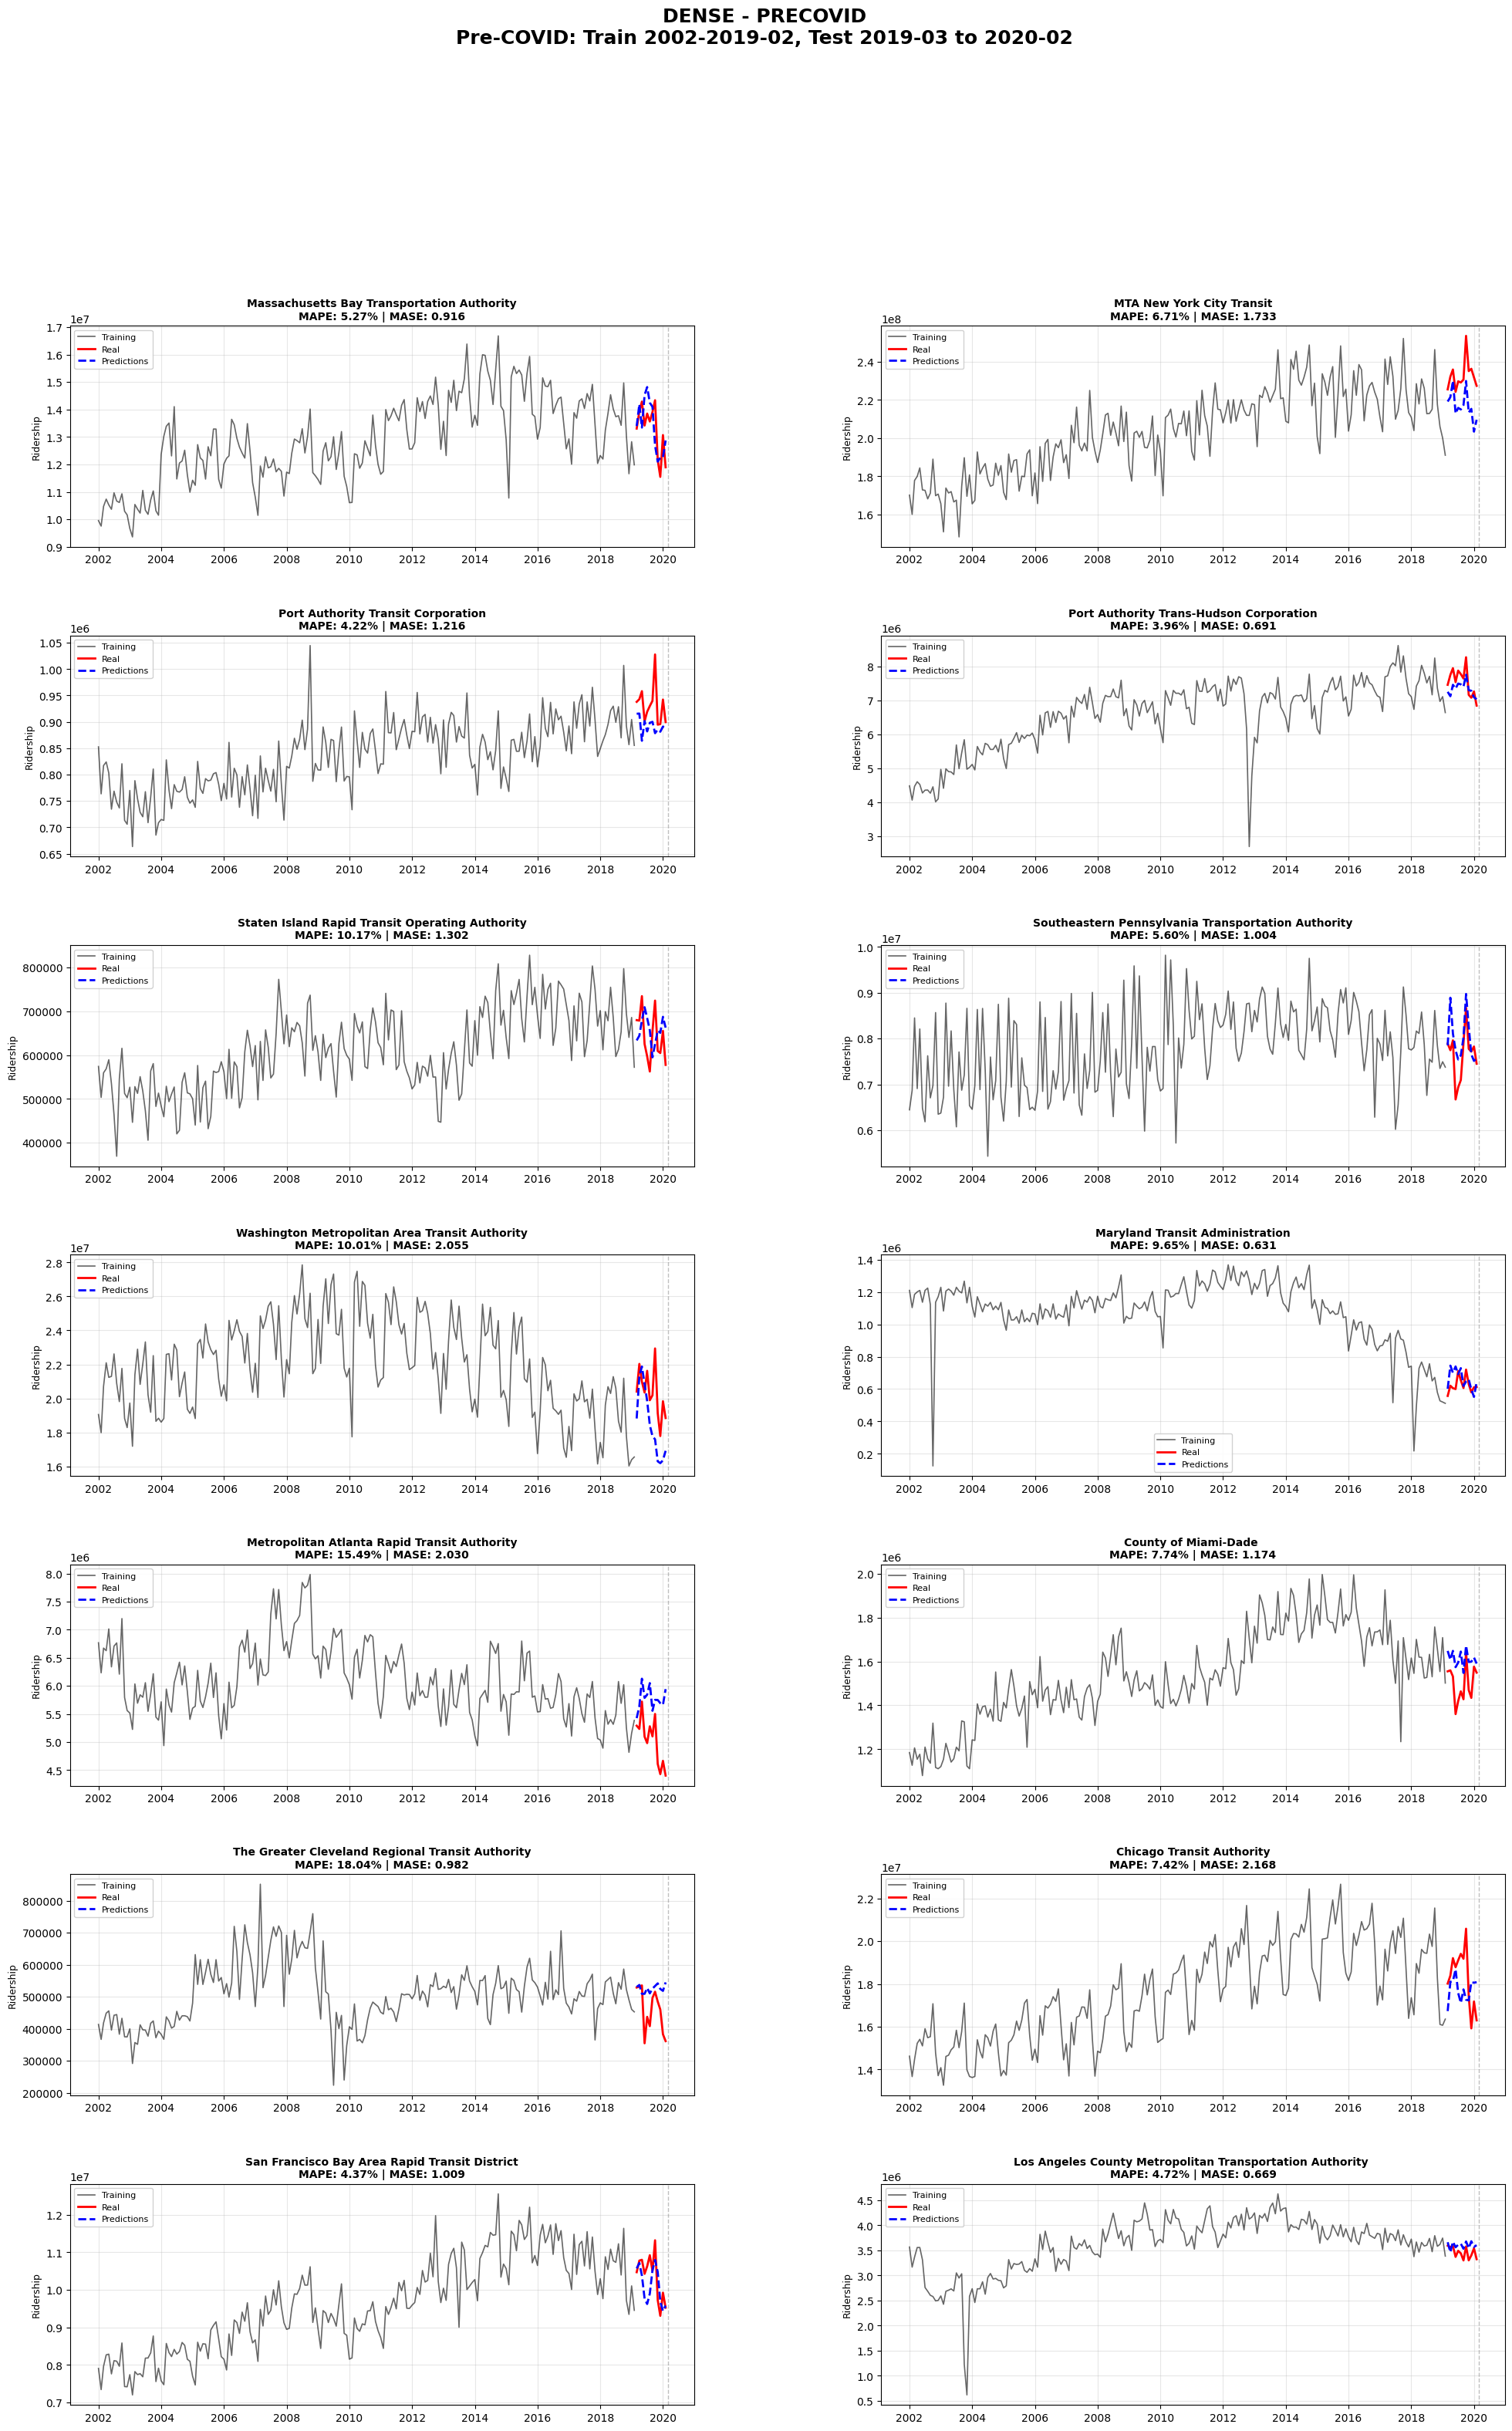


################################################################################
################################################################################
## ENTRENANDO: CNN - PRECOVID
################################################################################
################################################################################

 Massachusetts Bay Transportation Authority - CNN - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 588327.22
📊 MAPE: 3.58%
📊 MASE: 0.614


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



 MTA New York City Transit - CNN - PRECOVID
 Entrenando...
📊 RMSE: 12652923.79
📊 MAPE: 4.16%
📊 MASE: 1.064

 Port Authority Transit Corporation - CNN - PRECOVID
 Entrenando...
📊 RMSE: 12652923.79
📊 MAPE: 4.16%
📊 MASE: 1.064

 Port Authority Transit Corporation - CNN - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 55280.11
📊 MAPE: 5.34%
📊 MASE: 1.502

 Port Authority Trans-Hudson Corporation - CNN - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 237192.20
📊 MAPE: 2.62%
📊 MASE: 0.450

 Staten Island Rapid Transit Operating Authority - CNN - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 30275.56
📊 MAPE: 3.52%
📊 MASE: 0.464

 Southeastern Pennsylvania Transportation Authority - CNN - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 378711.69
📊 MAPE: 4.23%
📊 MASE: 0.783

 Washington Metropolitan Area Transit Authority - CNN - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 1706560.53
📊 MAPE: 7.57%
📊 MASE: 1.559

 Maryland Transit Administration - CNN - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 201203.04
📊 MAPE: 28.32%
📊 MASE: 1.896

 Metropolitan Atlanta Rapid Transit Authority - CNN - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 537240.67
📊 MAPE: 9.90%
📊 MASE: 1.322

 County of Miami-Dade  - CNN - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 115152.71
📊 MAPE: 6.84%
📊 MASE: 1.043

 The Greater Cleveland Regional Transit Authority - CNN - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 79681.27
📊 MAPE: 15.49%
📊 MASE: 0.848

 Chicago Transit Authority - CNN - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 751064.88
📊 MAPE: 3.65%
📊 MASE: 1.055

 San Francisco Bay Area Rapid Transit District - CNN - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 357225.79
📊 MAPE: 2.92%
📊 MASE: 0.652

 Los Angeles County Metropolitan Transportation Authority  - CNN - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 195667.81
📊 MAPE: 5.10%
📊 MASE: 0.724

💾 Plot guardado: /home/carlos/IA/FINAL/time-series_forecasting/plots/precovid_cnn/all_agencies_precovid_cnn.png

💾 Plot guardado: /home/carlos/IA/FINAL/time-series_forecasting/plots/precovid_cnn/all_agencies_precovid_cnn.png


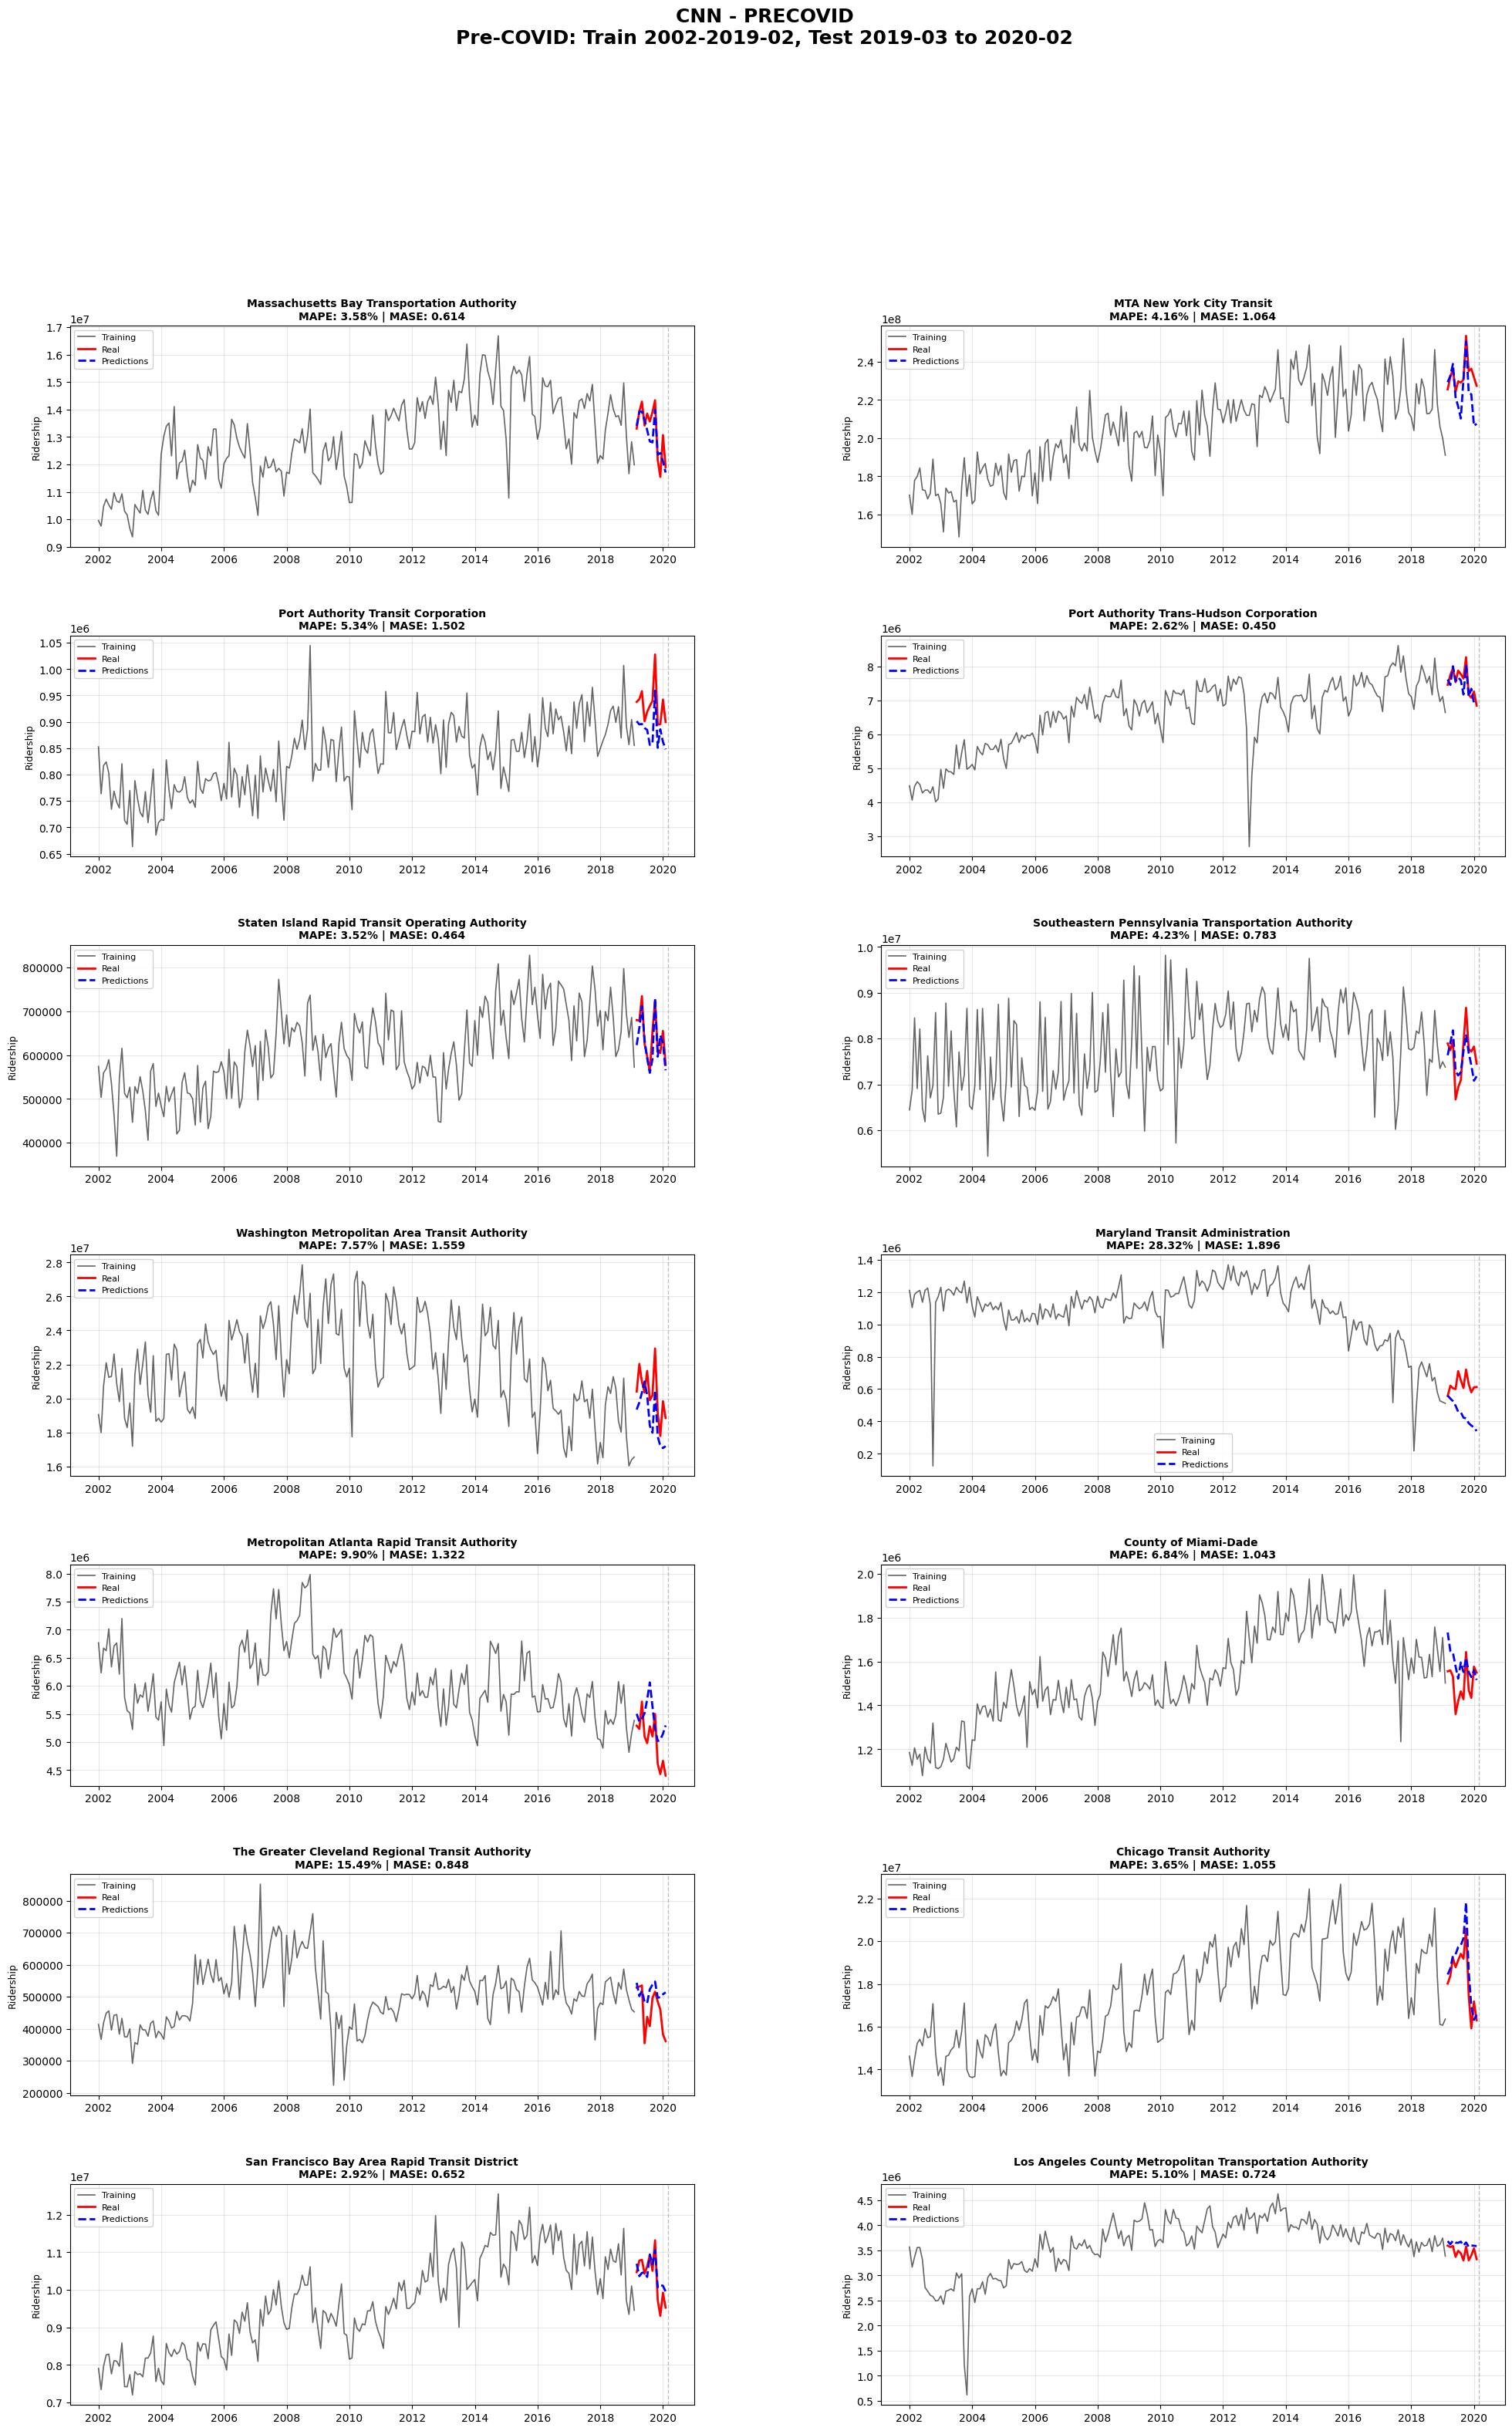


################################################################################
################################################################################
## ENTRENANDO: LSTM - PRECOVID
################################################################################
################################################################################


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 Massachusetts Bay Transportation Authority - LSTM - PRECOVID
 Entrenando...
📊 RMSE: 722689.05
📊 MAPE: 4.86%
📊 MASE: 0.844

 MTA New York City Transit - LSTM - PRECOVID
 Entrenando...
📊 RMSE: 722689.05
📊 MAPE: 4.86%
📊 MASE: 0.844

 MTA New York City Transit - LSTM - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 20947743.02
📊 MAPE: 8.44%
📊 MASE: 2.177

 Port Authority Transit Corporation - LSTM - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 42699.13
📊 MAPE: 3.74%
📊 MASE: 1.063

 Port Authority Trans-Hudson Corporation - LSTM - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 340161.25
📊 MAPE: 3.98%
📊 MASE: 0.666

 Staten Island Rapid Transit Operating Authority - LSTM - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 35200.44
📊 MAPE: 4.80%
📊 MASE: 0.638

 Southeastern Pennsylvania Transportation Authority - LSTM - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 452728.30
📊 MAPE: 4.41%
📊 MASE: 0.794

 Washington Metropolitan Area Transit Authority - LSTM - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 2492035.44
📊 MAPE: 11.44%
📊 MASE: 2.349

 Maryland Transit Administration - LSTM - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 168376.96
📊 MAPE: 24.67%
📊 MASE: 1.652

 Metropolitan Atlanta Rapid Transit Authority - LSTM - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 437968.14
📊 MAPE: 7.76%
📊 MASE: 1.031

 County of Miami-Dade  - LSTM - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 186297.13
📊 MAPE: 11.83%
📊 MASE: 1.807

 The Greater Cleveland Regional Transit Authority - LSTM - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 98509.10
📊 MAPE: 19.97%
📊 MASE: 1.106

 Chicago Transit Authority - LSTM - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 717872.49
📊 MAPE: 3.17%
📊 MASE: 0.927

 San Francisco Bay Area Rapid Transit District - LSTM - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 433389.37
📊 MAPE: 3.50%
📊 MASE: 0.772

 Los Angeles County Metropolitan Transportation Authority  - LSTM - PRECOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 327525.50
📊 MAPE: 9.10%
📊 MASE: 1.318

💾 Plot guardado: /home/carlos/IA/FINAL/time-series_forecasting/plots/precovid_lstm/all_agencies_precovid_lstm.png

💾 Plot guardado: /home/carlos/IA/FINAL/time-series_forecasting/plots/precovid_lstm/all_agencies_precovid_lstm.png


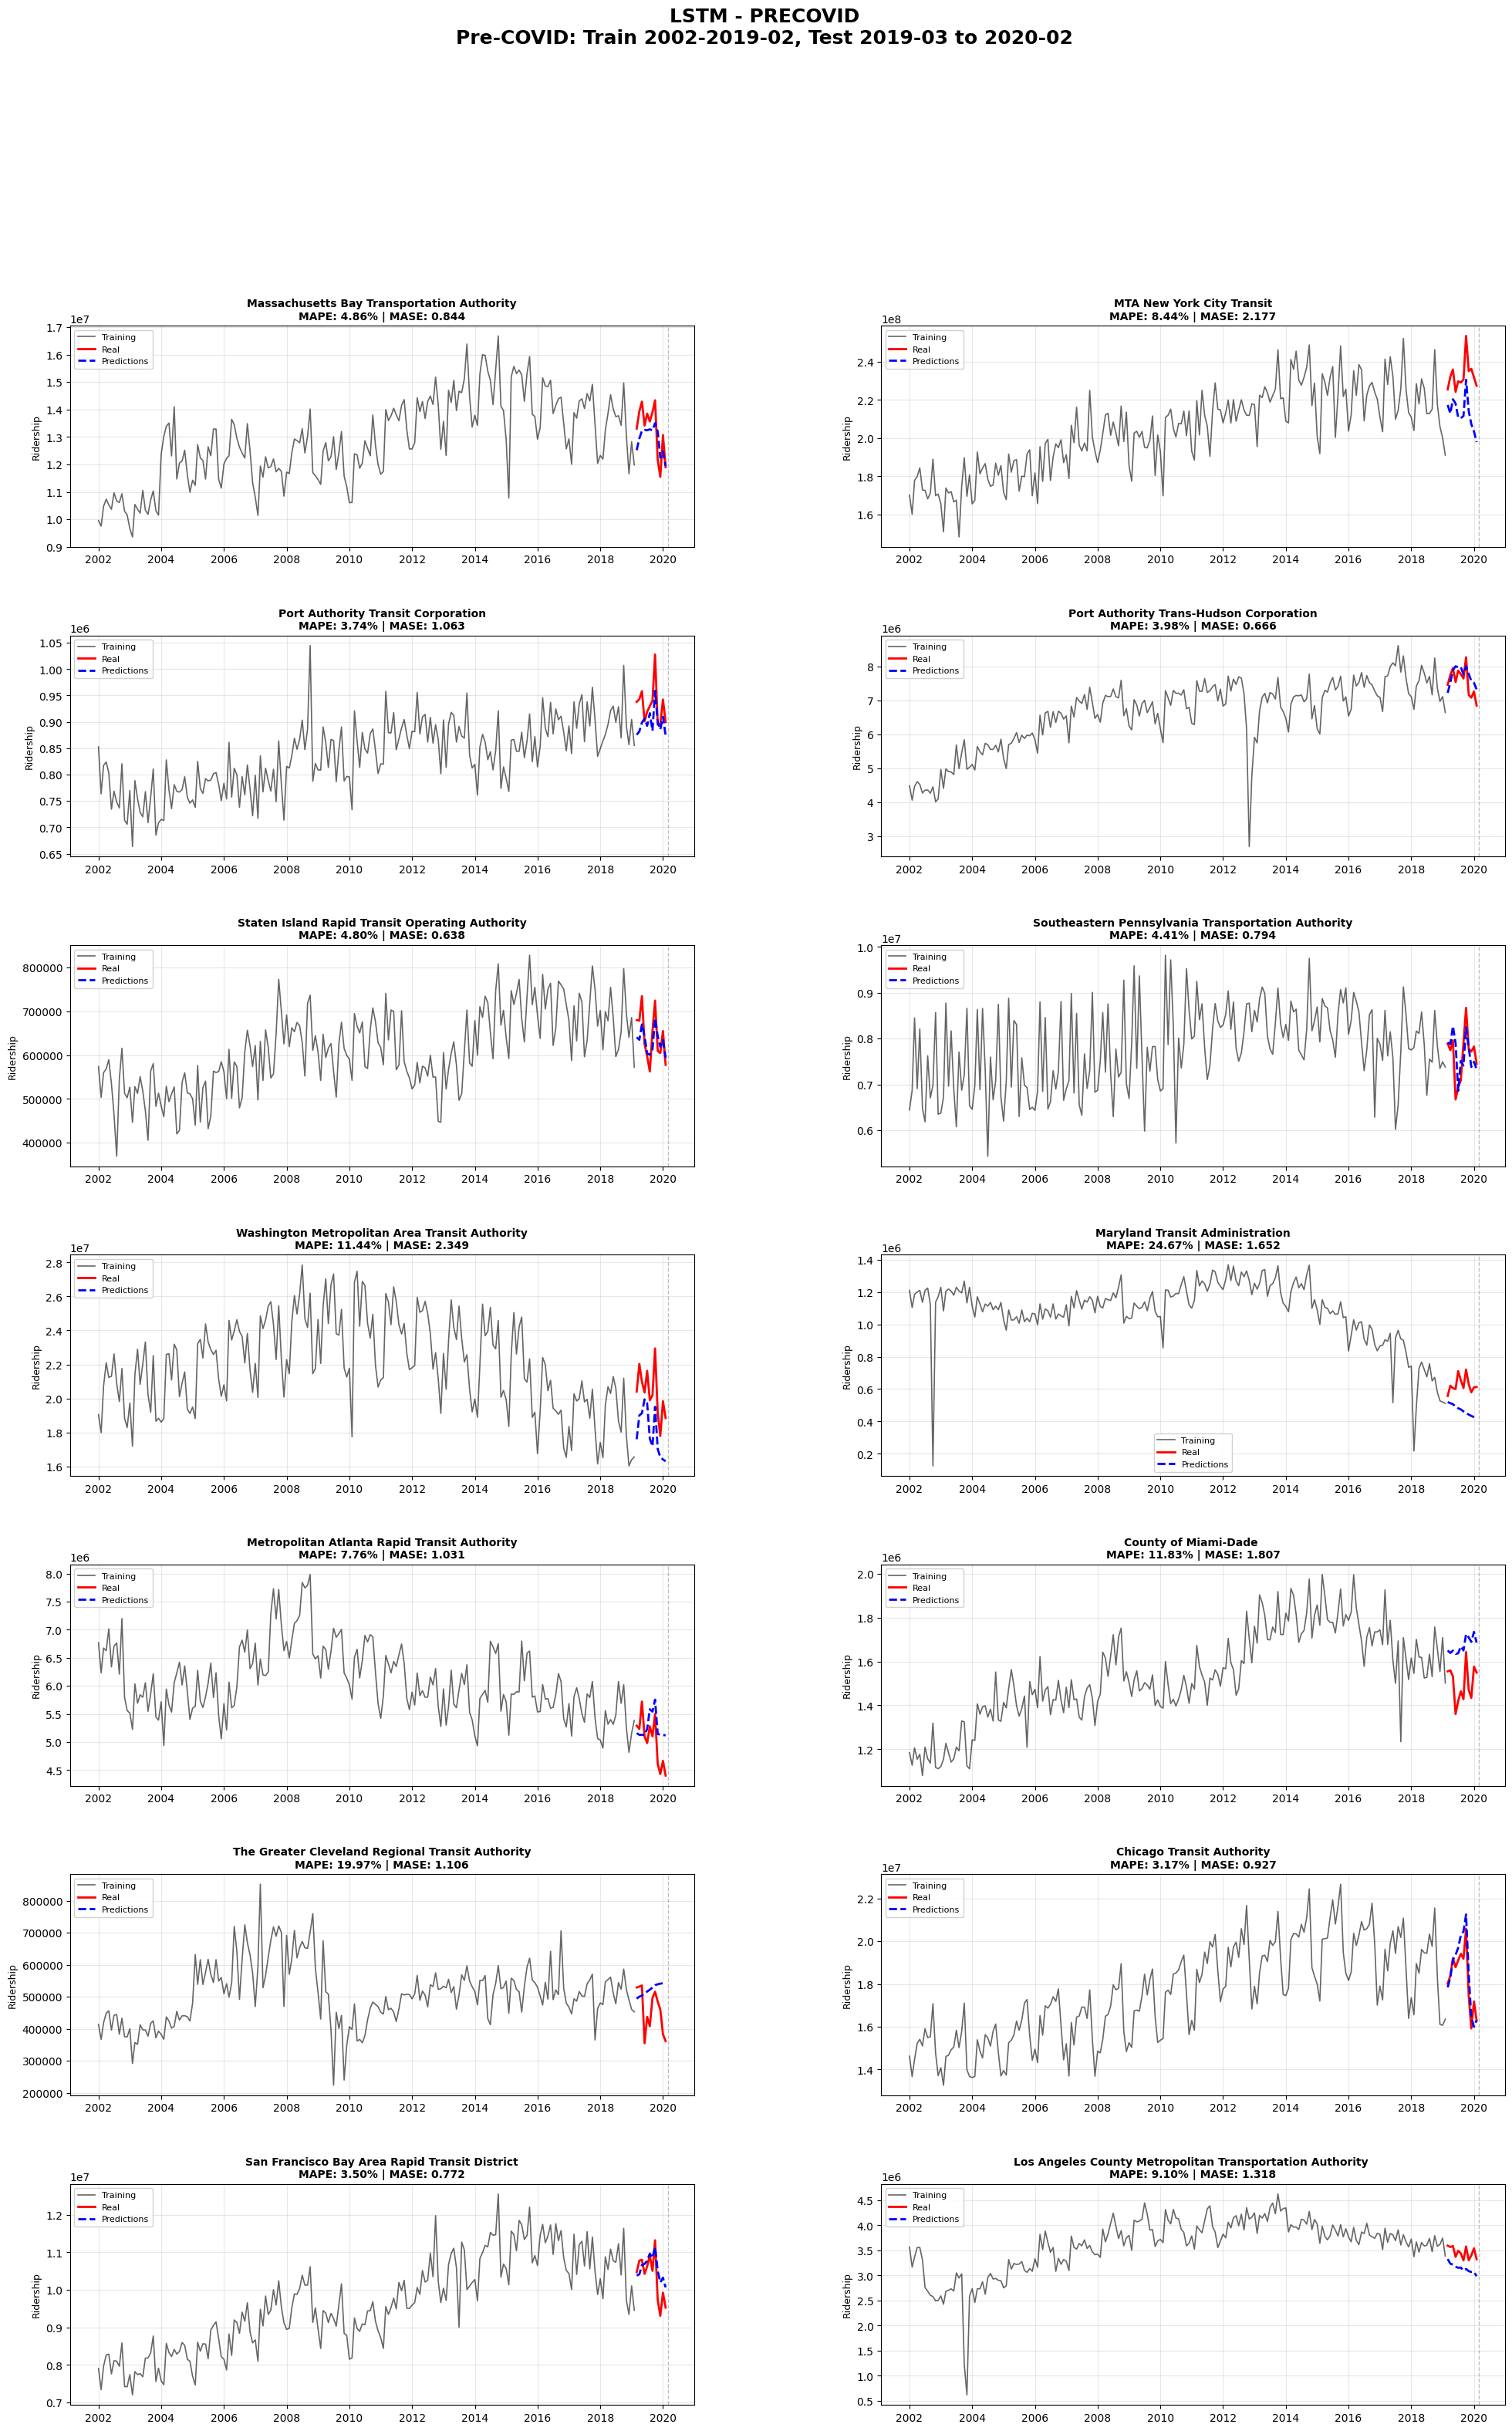


################################################################################
################################################################################
## ENTRENANDO: DENSE - POSTCOVID
################################################################################
################################################################################

 Massachusetts Bay Transportation Authority - DENSE - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 5285075.43
📊 MAPE: 68.89%
📊 MASE: 2.169

 MTA New York City Transit - DENSE - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 26228090.98
📊 MAPE: 14.46%
📊 MASE: 0.492

 Port Authority Transit Corporation - DENSE - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 66264.54
📊 MAPE: 12.67%
📊 MASE: 0.450

 Port Authority Trans-Hudson Corporation - DENSE - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 2010017.00
📊 MAPE: 40.92%
📊 MASE: 1.336

 Staten Island Rapid Transit Operating Authority - DENSE - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 48521.09
📊 MAPE: 9.50%
📊 MASE: 0.396

 Southeastern Pennsylvania Transportation Authority - DENSE - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 1549102.63
📊 MAPE: 31.19%
📊 MASE: 0.964

 Washington Metropolitan Area Transit Authority - DENSE - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 1896789.66
📊 MAPE: 13.56%
📊 MASE: 0.462

 Maryland Transit Administration - DENSE - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 110191.03
📊 MAPE: 60.77%
📊 MASE: 1.508

 Metropolitan Atlanta Rapid Transit Authority - DENSE - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 309062.36
📊 MAPE: 9.83%
📊 MASE: 0.453

 County of Miami-Dade  - DENSE - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 995079.82
📊 MAPE: 84.06%
📊 MASE: 4.698

 The Greater Cleveland Regional Transit Authority - DENSE - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 128842.85
📊 MAPE: 43.20%
📊 MASE: 4.095

 Chicago Transit Authority - DENSE - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 1332343.28
📊 MAPE: 12.14%
📊 MASE: 0.404

 San Francisco Bay Area Rapid Transit District - DENSE - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 2093145.46
📊 MAPE: 44.82%
📊 MASE: 1.347

 Los Angeles County Metropolitan Transportation Authority  - DENSE - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 600051.70
📊 MAPE: 23.65%
📊 MASE: 1.393

💾 Plot guardado: /home/carlos/IA/FINAL/time-series_forecasting/plots/postcovid_dense/all_agencies_postcovid_dense.png

💾 Plot guardado: /home/carlos/IA/FINAL/time-series_forecasting/plots/postcovid_dense/all_agencies_postcovid_dense.png


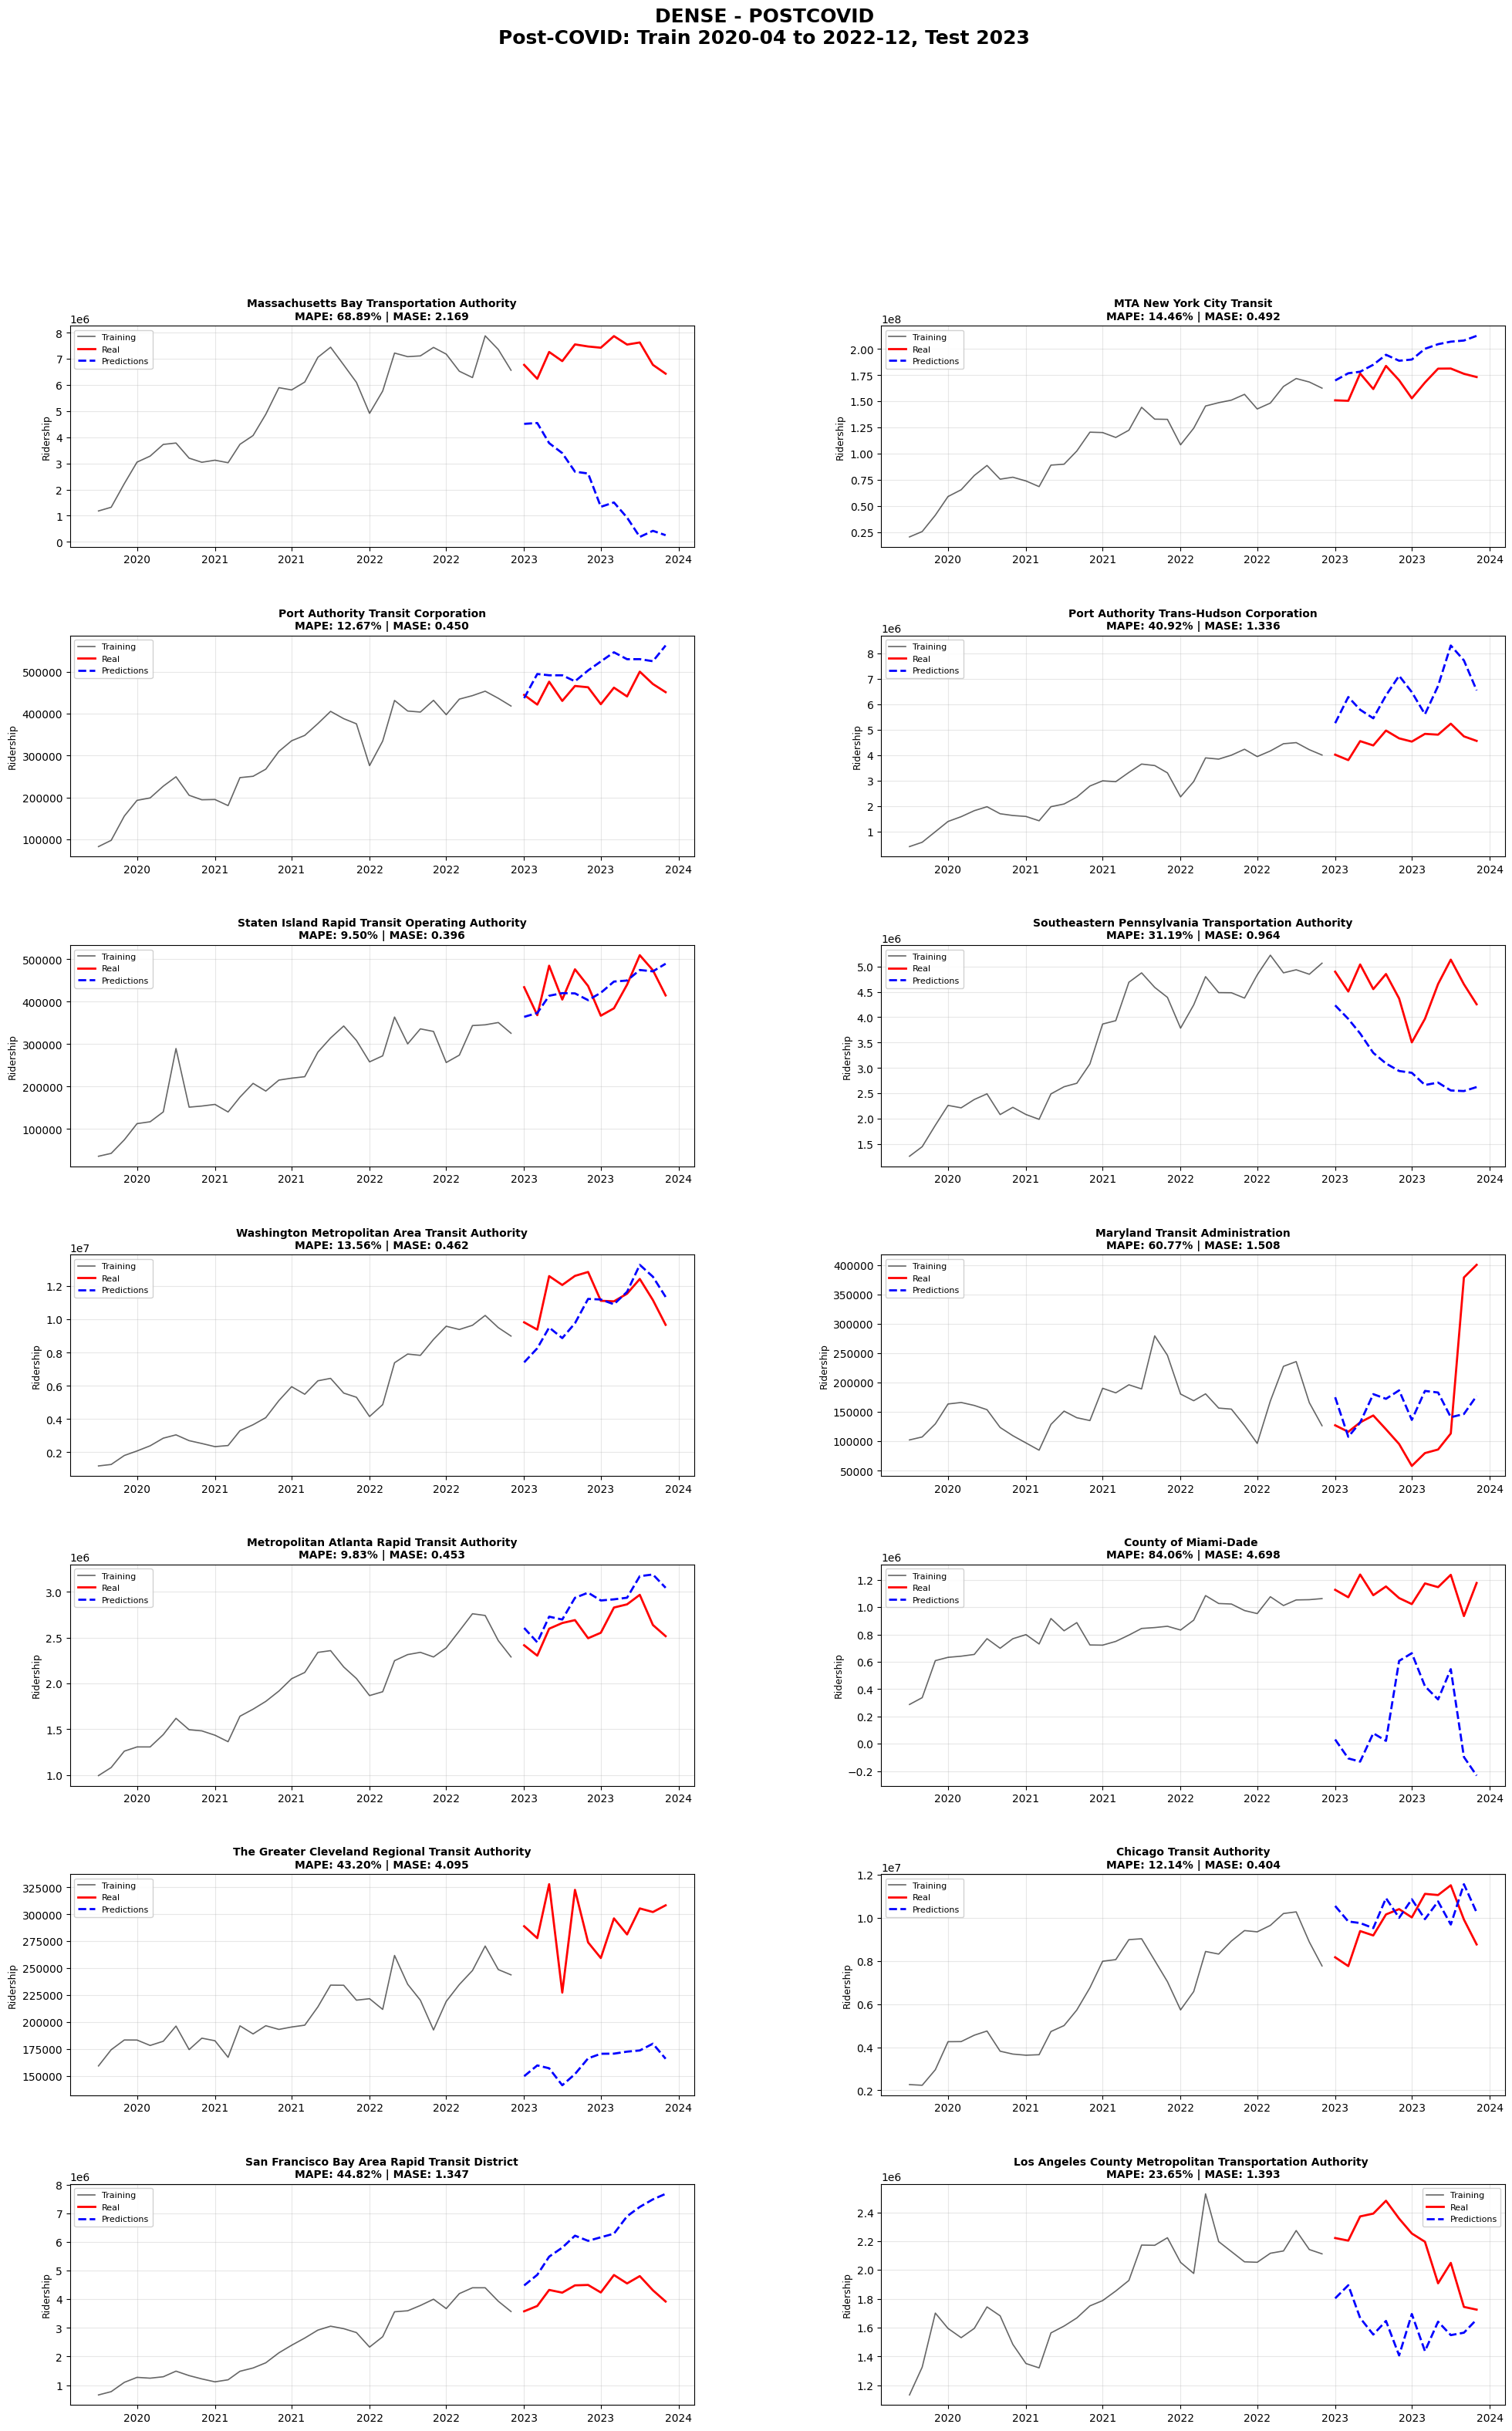


################################################################################
################################################################################
## ENTRENANDO: CNN - POSTCOVID
################################################################################
################################################################################

 Massachusetts Bay Transportation Authority - CNN - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 567373.95
📊 MAPE: 6.33%
📊 MASE: 0.187

 MTA New York City Transit - CNN - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 8948855.03
📊 MAPE: 4.63%
📊 MASE: 0.158

 Port Authority Transit Corporation - CNN - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 21341.36
📊 MAPE: 4.13%
📊 MASE: 0.147

 Port Authority Trans-Hudson Corporation - CNN - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 251826.50
📊 MAPE: 4.15%
📊 MASE: 0.132

 Staten Island Rapid Transit Operating Authority - CNN - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 79617.20
📊 MAPE: 15.49%
📊 MASE: 0.677

 Southeastern Pennsylvania Transportation Authority - CNN - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 589882.53
📊 MAPE: 10.60%
📊 MASE: 0.292

 Washington Metropolitan Area Transit Authority - CNN - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 3947067.99
📊 MAPE: 29.94%
📊 MASE: 0.976

 Maryland Transit Administration - CNN - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 106637.76
📊 MAPE: 76.57%
📊 MASE: 1.592

 Metropolitan Atlanta Rapid Transit Authority - CNN - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 128528.18
📊 MAPE: 4.13%
📊 MASE: 0.191

 County of Miami-Dade  - CNN - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 244716.39
📊 MAPE: 19.38%
📊 MASE: 1.040

 The Greater Cleveland Regional Transit Authority - CNN - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 32220.01
📊 MAPE: 9.80%
📊 MASE: 0.891

 Chicago Transit Authority - CNN - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 743765.79
📊 MAPE: 6.47%
📊 MASE: 0.227

 San Francisco Bay Area Rapid Transit District - CNN - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📊 RMSE: 639482.98
📊 MAPE: 13.68%
📊 MASE: 0.394


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



 Los Angeles County Metropolitan Transportation Authority  - CNN - POSTCOVID
 Entrenando...
📊 RMSE: 253649.47
📊 MAPE: 10.94%
📊 MASE: 0.612
📊 RMSE: 253649.47
📊 MAPE: 10.94%
📊 MASE: 0.612

💾 Plot guardado: /home/carlos/IA/FINAL/time-series_forecasting/plots/postcovid_cnn/all_agencies_postcovid_cnn.png

💾 Plot guardado: /home/carlos/IA/FINAL/time-series_forecasting/plots/postcovid_cnn/all_agencies_postcovid_cnn.png


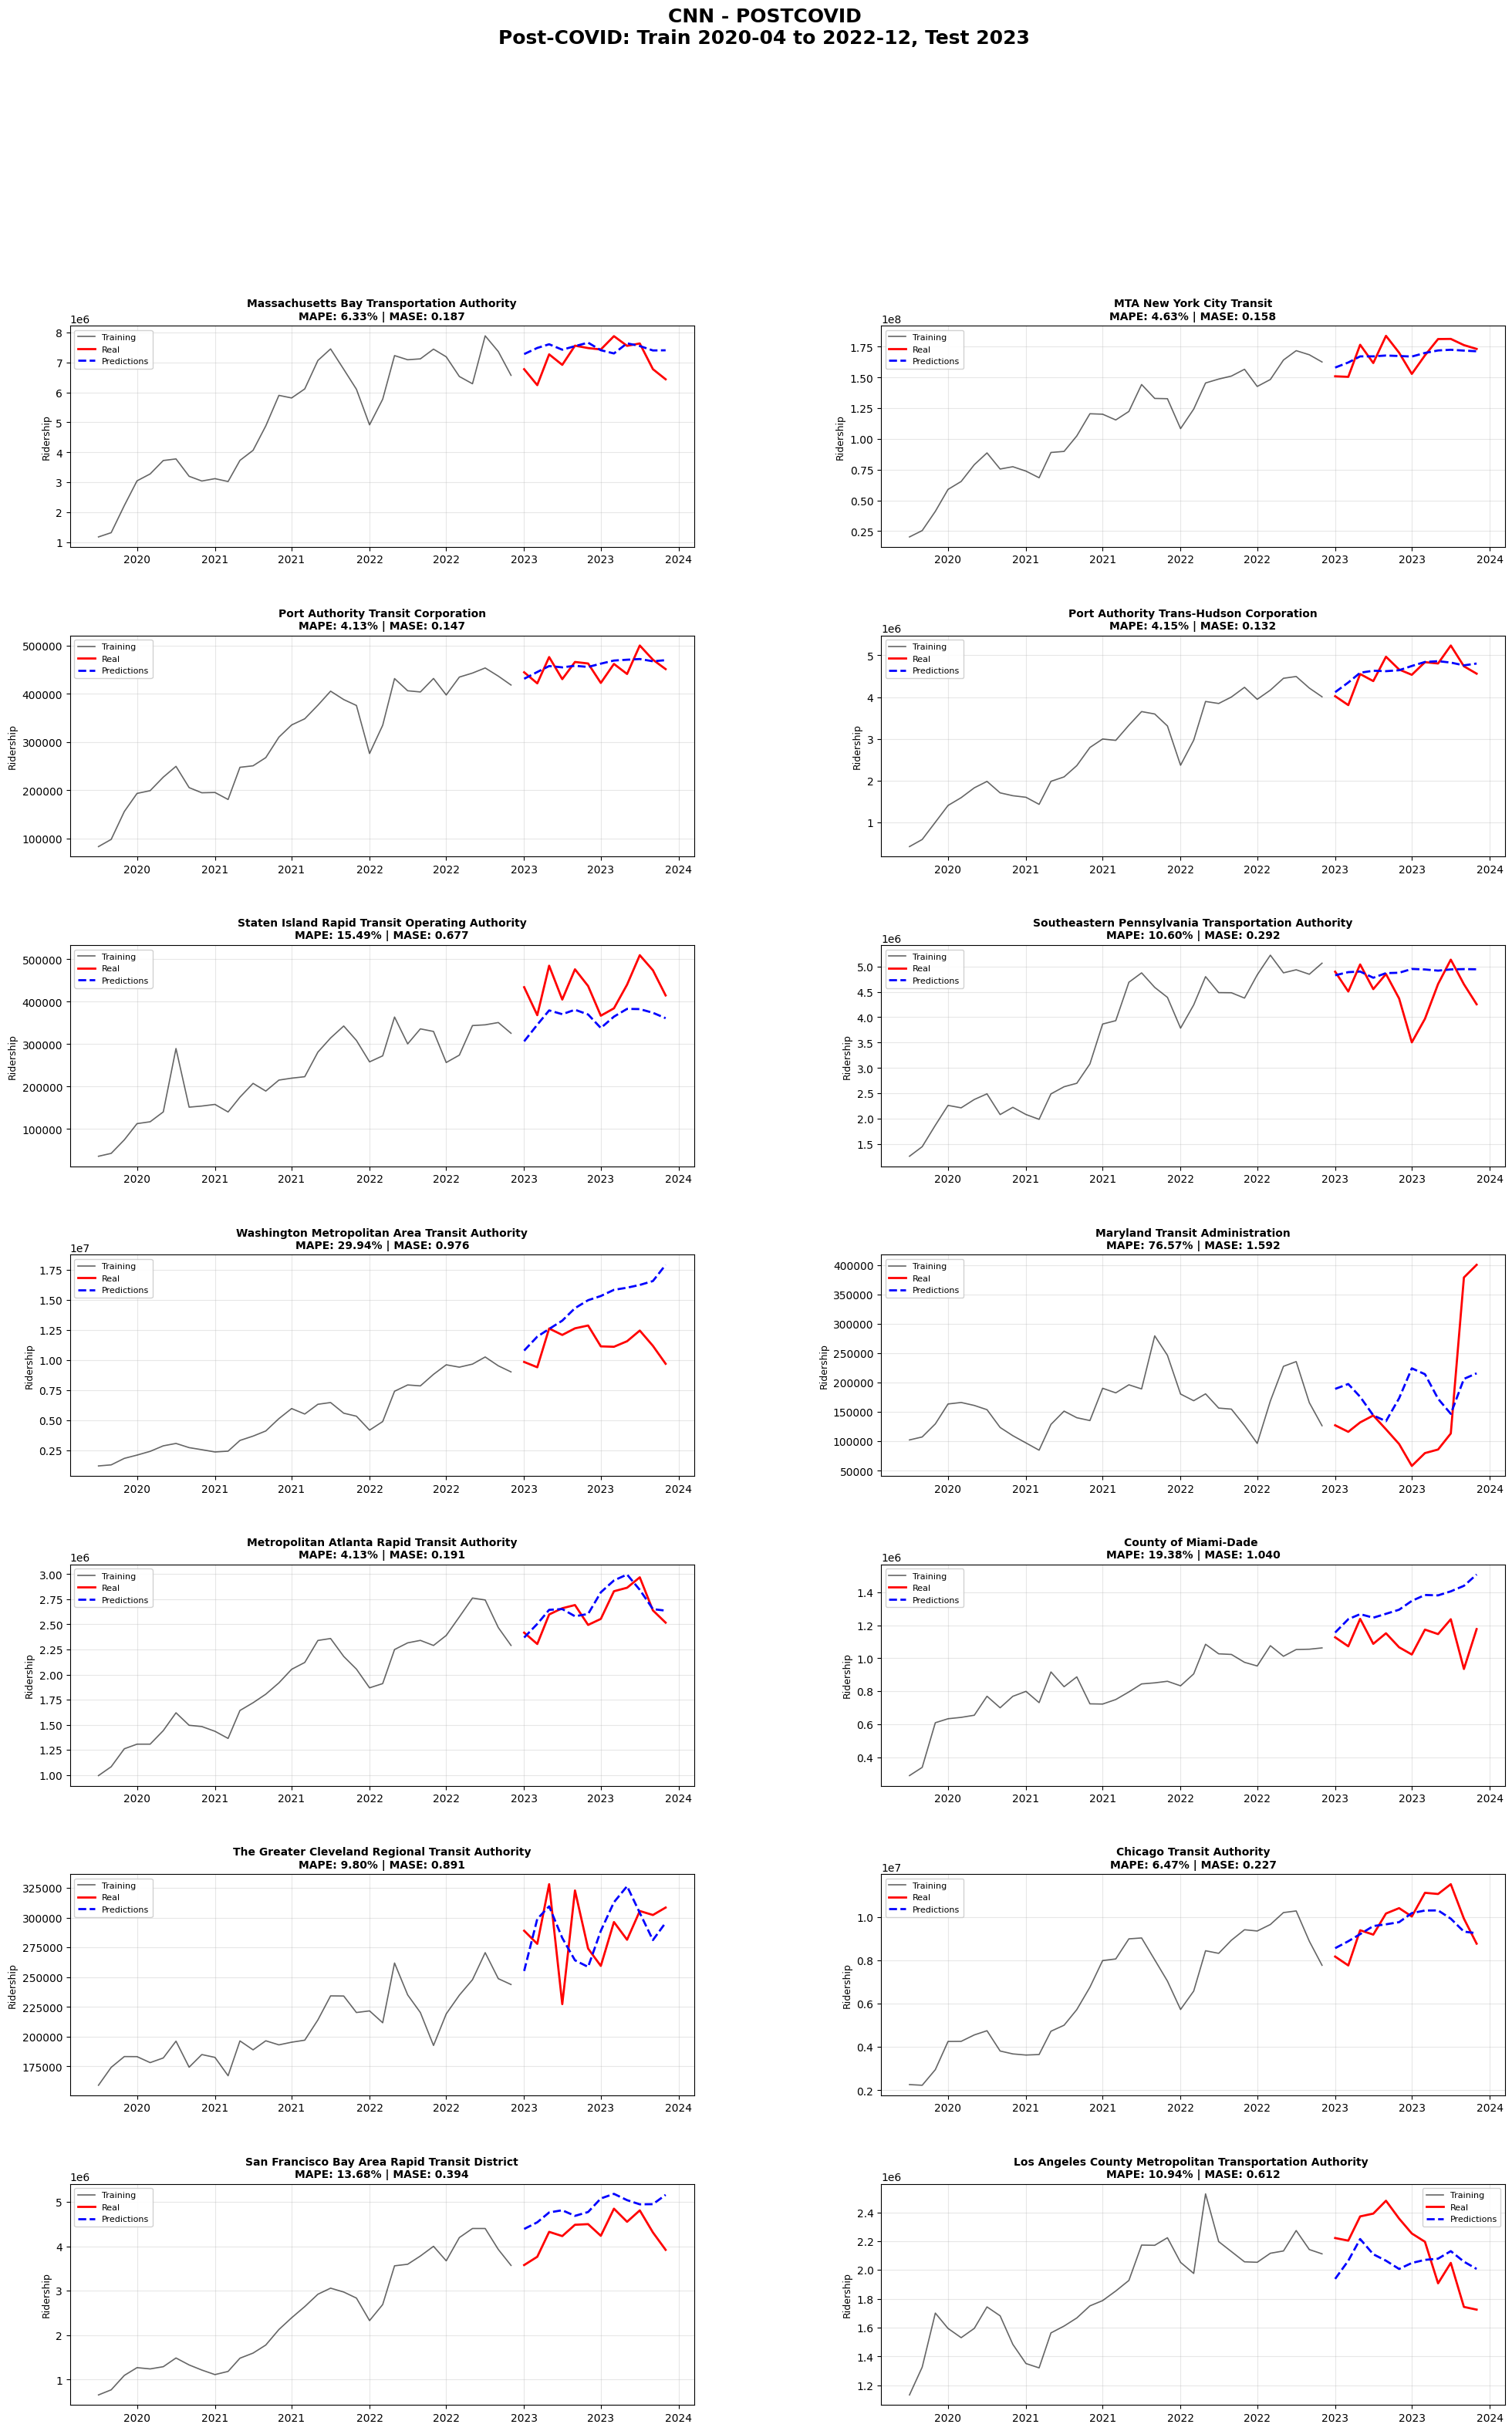


################################################################################
################################################################################
## ENTRENANDO: LSTM - POSTCOVID
################################################################################
################################################################################


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 Massachusetts Bay Transportation Authority - LSTM - POSTCOVID
 Entrenando...
 Entrenando...
📊 RMSE: 517996.76
📊 MAPE: 6.45%
📊 MASE: 0.202

 MTA New York City Transit - LSTM - POSTCOVID
 Entrenando...
📊 RMSE: 517996.76
📊 MAPE: 6.45%
📊 MASE: 0.202

 MTA New York City Transit - LSTM - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 11178474.61
📊 MAPE: 5.77%
📊 MASE: 0.190


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 Port Authority Transit Corporation - LSTM - POSTCOVID
 Entrenando...
📊 RMSE: 20972.50
📊 MAPE: 3.91%
📊 MASE: 0.141

 Port Authority Trans-Hudson Corporation - LSTM - POSTCOVID
 Entrenando...
📊 RMSE: 20972.50
📊 MAPE: 3.91%
📊 MASE: 0.141

 Port Authority Trans-Hudson Corporation - LSTM - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 601298.70
📊 MAPE: 12.22%
📊 MASE: 0.388

 Staten Island Rapid Transit Operating Authority - LSTM - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 93662.09
📊 MAPE: 18.33%
📊 MASE: 0.805

 Southeastern Pennsylvania Transportation Authority - LSTM - POSTCOVID


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 Entrenando...
📊 RMSE: 1008258.86
📊 MAPE: 20.76%
📊 MASE: 0.593
📊 RMSE: 1008258.86
📊 MAPE: 20.76%
📊 MASE: 0.593


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 Washington Metropolitan Area Transit Authority - LSTM - POSTCOVID
 Entrenando...
📊 RMSE: 7148094.39
📊 MAPE: 53.32%
📊 MASE: 1.762
📊 RMSE: 7148094.39
📊 MAPE: 53.32%
📊 MASE: 1.762


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 Maryland Transit Administration - LSTM - POSTCOVID
 Entrenando...
📊 RMSE: 111928.99
📊 MAPE: 70.09%
📊 MASE: 1.666
📊 RMSE: 111928.99
📊 MAPE: 70.09%
📊 MASE: 1.666


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 Metropolitan Atlanta Rapid Transit Authority - LSTM - POSTCOVID
 Entrenando...
📊 RMSE: 382520.64
📊 MAPE: 11.82%
📊 MASE: 0.560
📊 RMSE: 382520.64
📊 MAPE: 11.82%
📊 MASE: 0.560


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 County of Miami-Dade  - LSTM - POSTCOVID
 Entrenando...
📊 RMSE: 113394.28
📊 MAPE: 8.71%
📊 MASE: 0.496

 The Greater Cleveland Regional Transit Authority - LSTM - POSTCOVID
 Entrenando...
📊 RMSE: 113394.28
📊 MAPE: 8.71%
📊 MASE: 0.496

 The Greater Cleveland Regional Transit Authority - LSTM - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 52208.78
📊 MAPE: 15.76%
📊 MASE: 1.532

 Chicago Transit Authority - LSTM - POSTCOVID
 Entrenando...


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


📊 RMSE: 1146225.07
📊 MAPE: 9.48%
📊 MASE: 0.349


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 San Francisco Bay Area Rapid Transit District - LSTM - POSTCOVID
 Entrenando...
📊 RMSE: 290622.09
📊 MAPE: 5.88%
📊 MASE: 0.175
📊 RMSE: 290622.09
📊 MAPE: 5.88%
📊 MASE: 0.175


/home/carlos/.local/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 Los Angeles County Metropolitan Transportation Authority  - LSTM - POSTCOVID
 Entrenando...
📊 RMSE: 244479.71
📊 MAPE: 9.91%
📊 MASE: 0.525
📊 RMSE: 244479.71
📊 MAPE: 9.91%
📊 MASE: 0.525

💾 Plot guardado: /home/carlos/IA/FINAL/time-series_forecasting/plots/postcovid_lstm/all_agencies_postcovid_lstm.png

💾 Plot guardado: /home/carlos/IA/FINAL/time-series_forecasting/plots/postcovid_lstm/all_agencies_postcovid_lstm.png


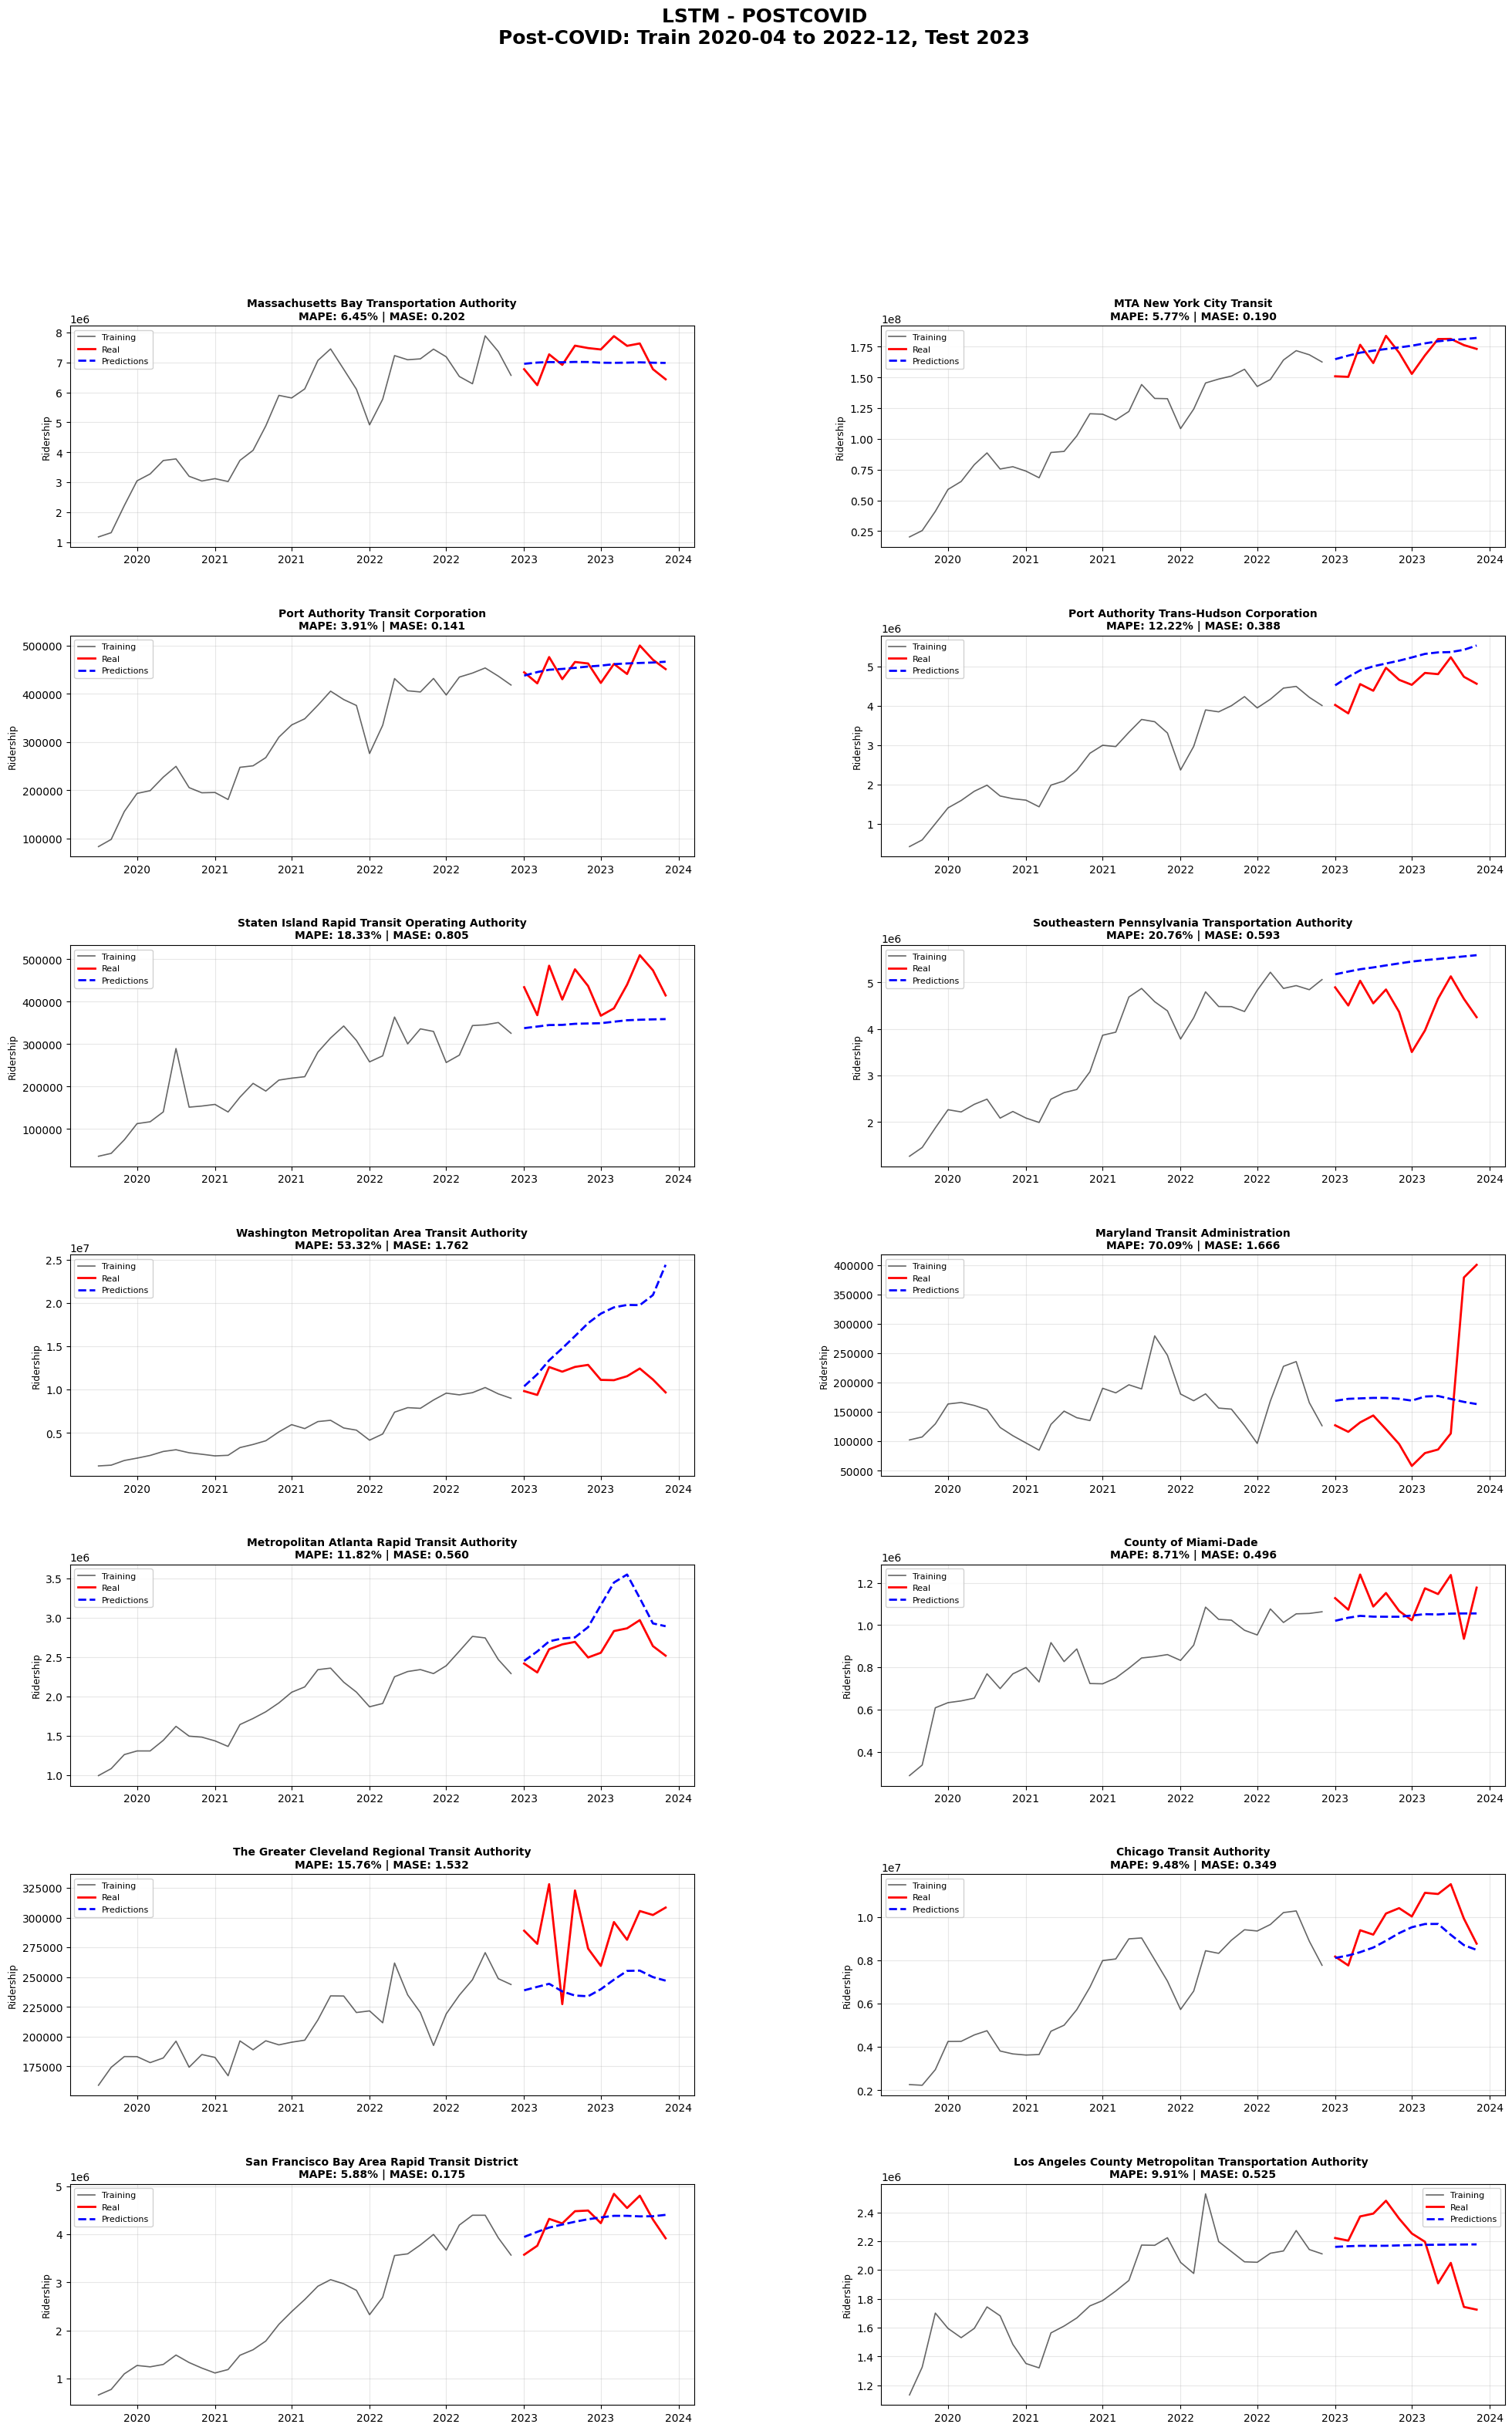


✅ ENTRENAMIENTO COMPLETO FINALIZADO


In [64]:
# ENTRENAMIENTO COMPLETO
all_results = []
model_types = ["dense", "cnn", "lstm"]
scenario_list = ["full", "precovid", "postcovid"]

print("\n" + "="*80)
print("🚀 INICIO DEL ENTRENAMIENTO COMPLETO")
print("="*80)
print(f"Modelos: {', '.join([m.upper() for m in model_types])}")
print(f"Escenarios: {', '.join([s.upper() for s in scenario_list])}")
print(f"Total: {len(model_types)} × {len(scenario_list)} × 14 = 126 modelos")
print("="*80)

# Loop principal
for scenario in scenario_list:
    for model_name in model_types:
        
        print(f"\n{'#'*80}")
        print(f"{'#'*80}")
        print(f"## ENTRENANDO: {model_name.upper()} - {scenario.upper()}")
        print(f"{'#'*80}")
        print(f"{'#'*80}")
        
        # Entrenar para las 14 agencias
        for agencia_id in range(1, 15):
            agencia_key = f"agencia{agencia_id}"
            agencia_name = agency_names_list[agencia_id - 1]
            df = agency_dataframes[agencia_key]
            
            # Construir modelo
            if model_name == "dense":
                model = build_dense_model(n_input, n_features)
            elif model_name == "cnn":
                model = build_cnn_model(n_input, n_features)
            else:  # lstm
                model = build_lstm_model(n_input, n_features)
            
            # Entrenar y evaluar
            result = train_and_evaluate(model, model_name, scenario, agencia_id, agencia_name, df)
            all_results.append(result)
        
        # Crear plot agrupado (14 agencias juntas) para esta combinación
        plot_grouped_agencies(all_results, model_name, scenario)

print("\n" + "="*80)
print("✅ ENTRENAMIENTO COMPLETO FINALIZADO")
print("="*80)

## 📊 RESUMEN DE RESULTADOS

In [66]:
# Crear tabla de resumen
summary_data = []
for result in all_results:
    summary_data.append({
        'Agency': result['agencia_name'],
        'Model': result['model'].upper(),
        'Scenario': result['scenario'].upper(),
        'MAPE (%)': result['mape'],
        'MASE': result['mase'],
        'RMSE': result['rmse']
    })

summary_df = pd.DataFrame(summary_data)

# Resumen por modelo y escenario
print("\n" + "="*100)
print("📊 RESUMEN PROMEDIO POR MODELO Y ESCENARIO")
print("="*100)

pivot_mape = summary_df.pivot_table(values='MAPE (%)', index='Model', columns='Scenario', aggfunc='mean')
pivot_mase = summary_df.pivot_table(values='MASE', index='Model', columns='Scenario', aggfunc='mean')
pivot_rmse = summary_df.pivot_table(values='RMSE', index='Model', columns='Scenario', aggfunc='mean')

print("\nMAPE Promedio (%):")
print(pivot_mape)
print("\nMASE Promedio:")
print(pivot_mase)
print("\nRMSE Promedio:")
print(pivot_rmse)
print("="*100)

# Guardar resultados completos en Excel
excel_path = "/home/carlos/IA/FINAL/time-series_forecasting/data/resultados_completos_simple.xlsx"
os.makedirs(os.path.dirname(excel_path), exist_ok=True)

with pd.ExcelWriter(excel_path) as writer:
    summary_df.to_excel(writer, sheet_name='Todos', index=False)
    pivot_mape.to_excel(writer, sheet_name='MAPE_Promedios')
    pivot_mase.to_excel(writer, sheet_name='MASE_Promedios')
    pivot_rmse.to_excel(writer, sheet_name='RMSE_Promedios')

print(f"\n💾 Resultados guardados en: {excel_path}")



📊 RESUMEN PROMEDIO POR MODELO Y ESCENARIO

MAPE Promedio (%):
Scenario       FULL  POSTCOVID  PRECOVID
Model                                   
CNN       14.813711  15.445223  7.373249
DENSE     19.759763  33.546866  8.098771
LSTM      19.562134  18.029135  8.691343

MASE Promedio:
Scenario      FULL  POSTCOVID  PRECOVID
Model                                  
CNN       0.667314   0.536896  0.998365
DENSE     0.929692   1.440470  1.255862
LSTM      0.799677   0.670268  1.224520

RMSE Promedio:
Scenario          FULL     POSTCOVID      PRECOVID
Model                                             
CNN       1.638268e+06  1.182498e+06  1.277608e+06
DENSE     1.450306e+06  3.046613e+06  1.774939e+06
LSTM      1.378842e+06  1.636438e+06  1.957371e+06

MAPE Promedio (%):
Scenario       FULL  POSTCOVID  PRECOVID
Model                                   
CNN       14.813711  15.445223  7.373249
DENSE     19.759763  33.546866  8.098771
LSTM      19.562134  18.029135  8.691343

MASE Promedio:
Scen